In [25]:
import cv2
from glob import glob
import matplotlib.pyplot as plt
from monai.data import DataLoader, Dataset
from monai.inferers import sliding_window_inference
from monai.networks.layers import Norm
from monai.networks.nets import UNet
from monai.transforms import(
    Compose,
    AddChanneld,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    NormalizeIntensityd, 
    ScaleIntensityRanged,
    CropForegroundd,
    Activations,
)
from monai.utils import first
import nibabel as nib
import numpy as np
import os
from skimage.transform import resize
import torch




In [4]:
# define the device used 
device = torch.device("cuda:0")
print(device)

cuda:0


In [5]:
# define the in_dir and model_dir according to the same way they were defined in the train.py script.

in_dir = '/home/alhajabdo/DataSets/SubTask1TrainValTest/'
model_dir = '/home/alhajabdo/Liver-Segmentation-Using-Monai-and-PyTorch/models/THE MODEL' 


In [6]:
# loads the metrics from the model :

train_loss = np.load(os.path.join(model_dir, 'loss_train.npy'))
train_metric = np.load(os.path.join(model_dir, 'metric_train.npy'))
test_loss = np.load(os.path.join(model_dir, 'loss_val.npy'))
test_metric = np.load(os.path.join(model_dir, 'metric_val.npy'))

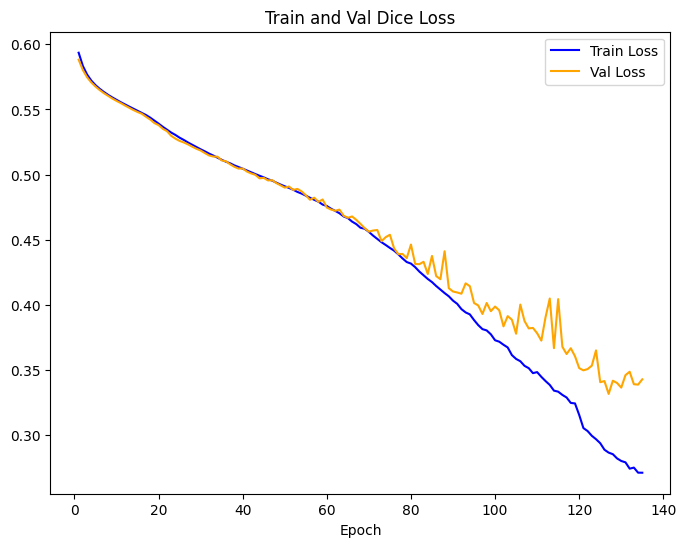

In [7]:


# Plot both training and val dice loss on the same graph
plt.figure(figsize=(8, 6))
plt.title("Train and Val Dice Loss")
x = [i + 1 for i in range(len(train_loss))]
plt.xlabel("Epoch")

plt.plot(x, train_loss, label="Train Loss", color="blue")
plt.plot(x, test_loss, label="Val Loss", color="orange")
plt.legend()
plt.show()
#plt.savefig(model_dir+"/dice_loss_plot.png")

# Display the plot
plt.show()

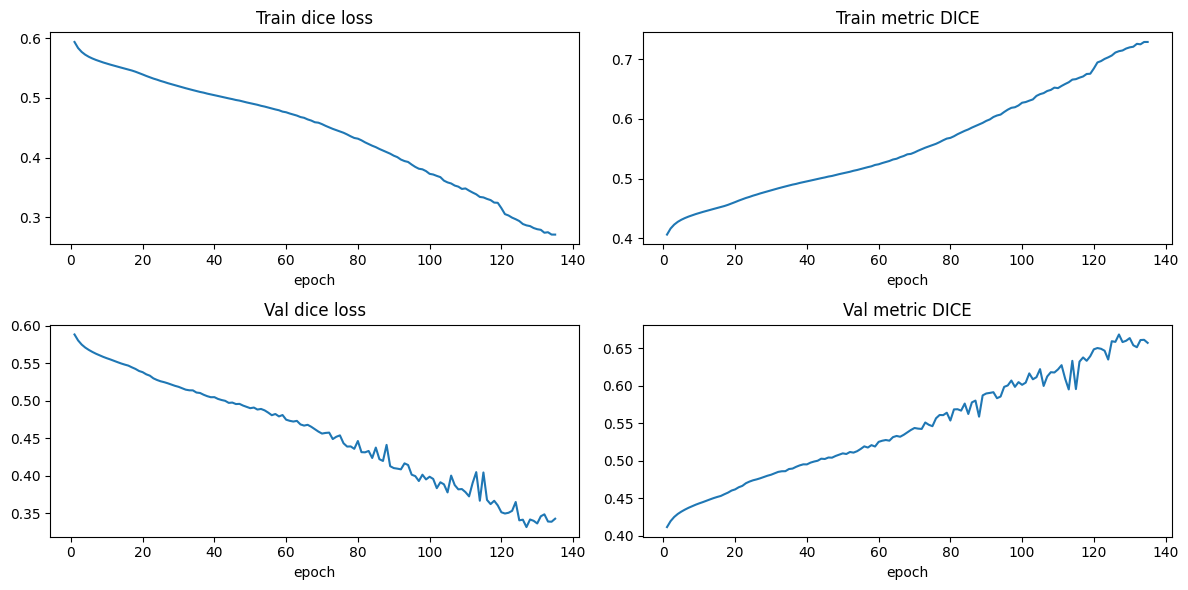

In [8]:
# plots the same metrics but separately 
plt.figure("Results 25 june", (12, 6))
plt.subplot(2, 2, 1)
plt.title("Train dice loss")
x = [i + 1 for i in range(len(train_loss))]
y = train_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 2)
plt.title("Train metric DICE")
x = [i + 1 for i in range(len(train_metric))]

y = train_metric
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 3)
plt.title("Val dice loss")
x = [i + 1 for i in range(len(test_loss))]
y = test_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 4)
plt.title("Val metric DICE")
x = [i + 1 for i in range(len(test_metric))]
y = test_metric
plt.xlabel("epoch")
plt.plot(x, y)
plt.tight_layout()
plt.show()

In [11]:
# loads the data 
path_train_volumes = sorted(glob(os.path.join(in_dir, "TrainVolumes", "*.nii.gz")))
path_train_segmentation = sorted(glob(os.path.join(in_dir, "TrainSegmentation", "*.nii.gz")))

path_val_volumes = sorted(glob(os.path.join(in_dir, "ValVolumes", "*.nii.gz")))
path_val_segmentation = sorted(glob(os.path.join(in_dir, "ValSegmentation", "*.nii.gz")))

train_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_train_volumes, path_train_segmentation)]
val_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_val_volumes, path_val_segmentation)]
# this allows you to define which files you specifically which files you want to view
val_files = val_files[5:20]

In [12]:
# to verify that you have selected the correct ones you can print them  :
print(val_files)

[{'vol': '/home/alhajabdo/DataSets/SubTask1TrainValTest/ValVolumes/train_0078_0000.nii_group_0.nii.gz', 'seg': '/home/alhajabdo/DataSets/SubTask1TrainValTest/ValSegmentation/train_0078.nii_class_4.nii_group_0.nii.gz'}, {'vol': '/home/alhajabdo/DataSets/SubTask1TrainValTest/ValVolumes/train_0079_0000.nii_group_0.nii.gz', 'seg': '/home/alhajabdo/DataSets/SubTask1TrainValTest/ValSegmentation/train_0079.nii_class_4.nii_group_0.nii.gz'}, {'vol': '/home/alhajabdo/DataSets/SubTask1TrainValTest/ValVolumes/train_0080_0000.nii_group_0.nii.gz', 'seg': '/home/alhajabdo/DataSets/SubTask1TrainValTest/ValSegmentation/train_0080.nii_class_4.nii_group_0.nii.gz'}, {'vol': '/home/alhajabdo/DataSets/SubTask1TrainValTest/ValVolumes/train_0082_0000.nii_group_1.nii.gz', 'seg': '/home/alhajabdo/DataSets/SubTask1TrainValTest/ValSegmentation/train_0082.nii_class_4.nii_group_1.nii.gz'}, {'vol': '/home/alhajabdo/DataSets/SubTask1TrainValTest/ValVolumes/train_0085_0000.nii_group_0.nii.gz', 'seg': '/home/alhajabdo/

In [13]:
# copy the the validation transformations form preproces  
pixdim=(1, 1, 1.0)
a_min=-150
a_max=170
spatial_size=[128,128,64]
val_transforms = Compose(
[
LoadImaged(keys=["vol", "seg"]),
AddChanneld(keys=["vol", "seg"]),
Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
Orientationd(keys=["vol", "seg"], axcodes="RAS"),
NormalizeIntensityd(keys=['vol']), 
ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max,b_min=0.0, b_max=1.0, clip=True), 
CropForegroundd(keys=['vol', 'seg'], source_key='vol'),
Resized(keys=["vol", "seg"], spatial_size=spatial_size),   
ToTensord(keys=["vol", "seg"]),


]
)

/home/alhajabdo/.local/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)
/home/alhajabdo/.local/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:111: FutureWarning: <class 'monai.transforms.utility.dictionary.AddChanneld'>: Class `AddChanneld` has been deprecated since version 0.8. It will be removed in version 1.3. please use MetaTensor data type and monai.transforms.EnsureChannelFirstd instead with `channel_dim='no_channel'`.
  warn_deprecated(obj, msg, warning_category)
/home/alhajabdo/.local/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.transforms.utility.dictionary EnsureChannelFirstd.__init__:meta_keys: Argument `meta_keys` has been deprecated 

In [17]:
# create the data loader
val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1)

In [18]:
# define the model you want to be uesd. This must be the same one used in the train or else errors will occur when loading the weights from the trained model

device = torch.device("cuda:0")
model = UNet(
spatial_dims=3,
in_channels=1,
out_channels=2,
channels=(16, 32, 64, 128, 256), 
strides=(2, 2, 2, 2),
num_res_units=2,
norm=Norm.BATCH,
).to(device)


In [19]:
# load the model by changing the file name betwen ''. you can either choose specific checkpoints from the model if you want to test specific epochs or choose the 'best_metric_model.pth'
model.load_state_dict(torch.load(
os.path.join(model_dir, 'checkpoint_epoch_121_0.6502415449232668.pth')))
model.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


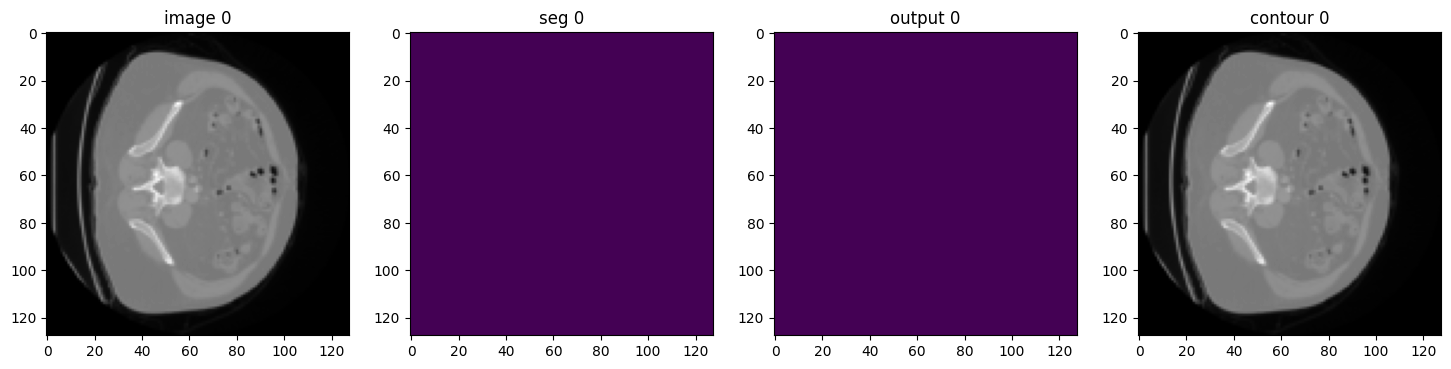

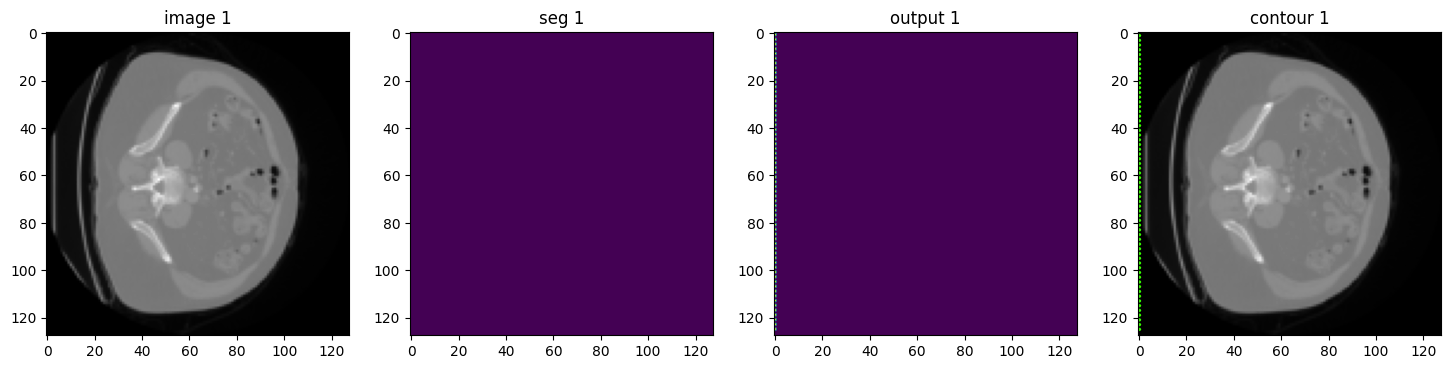

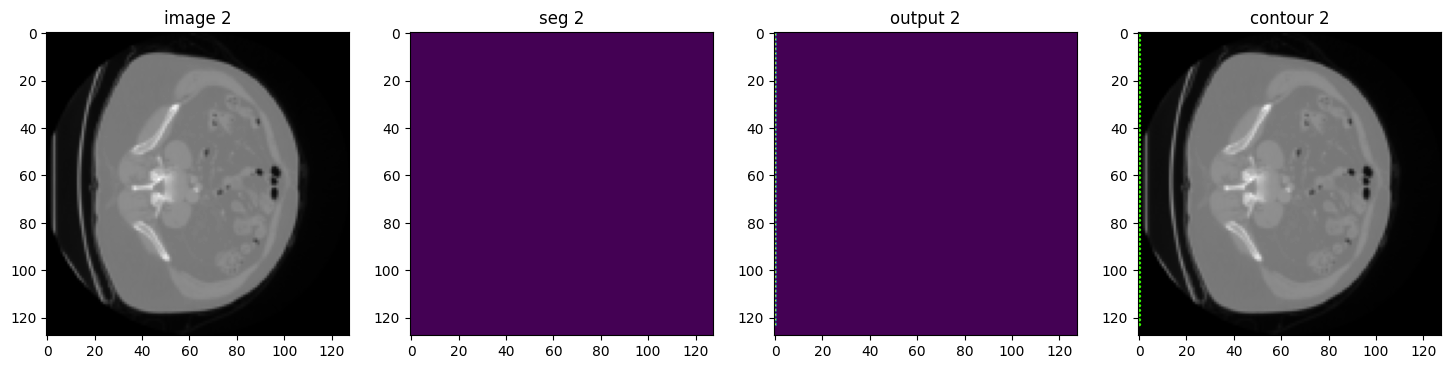

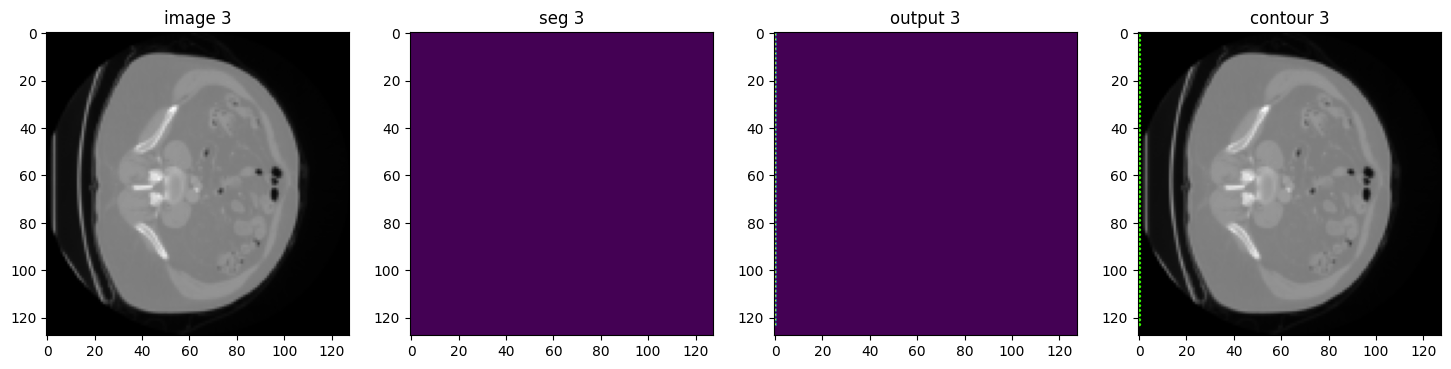

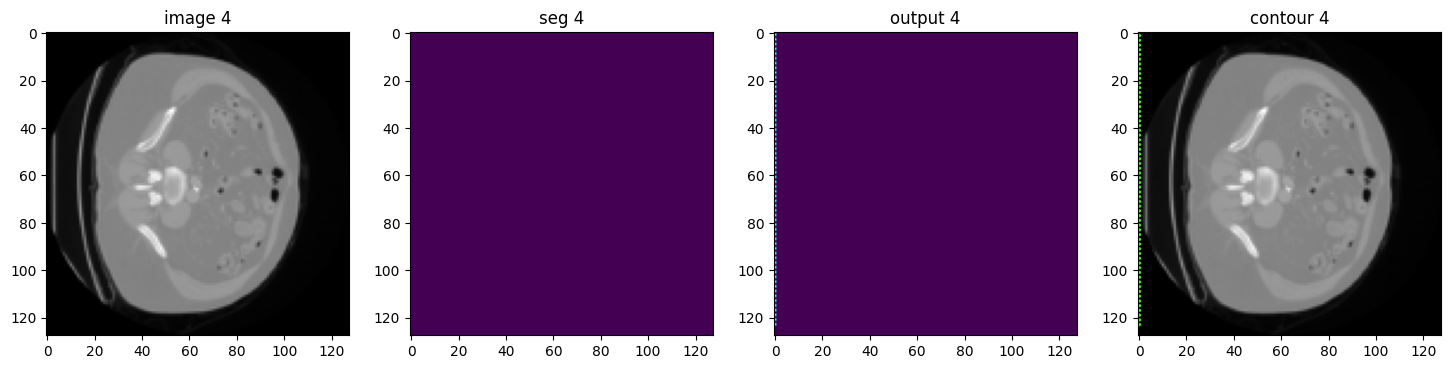

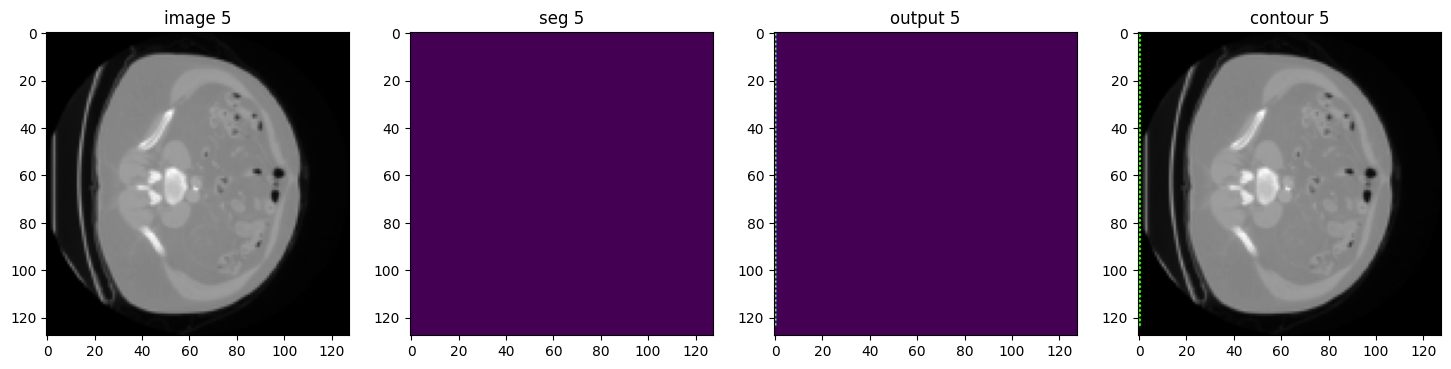

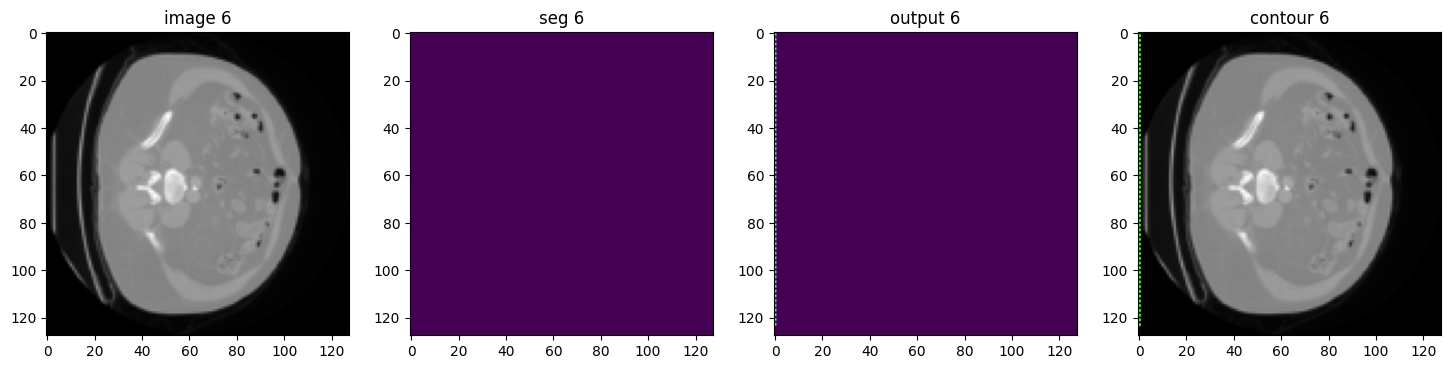

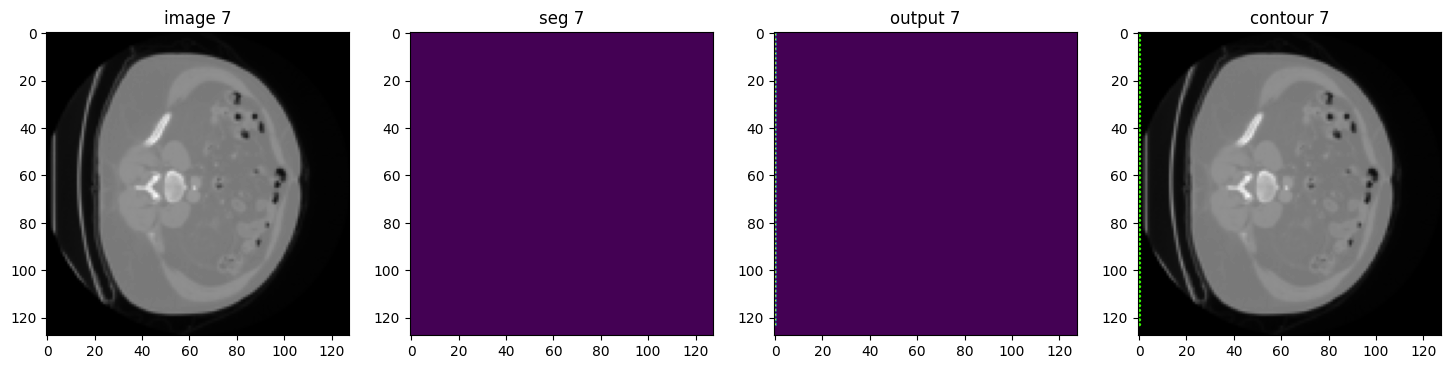

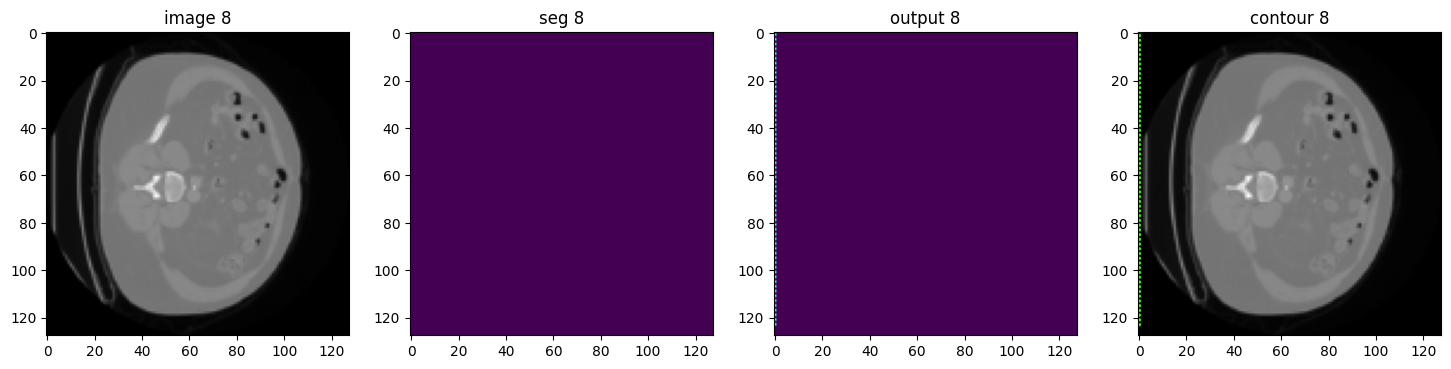

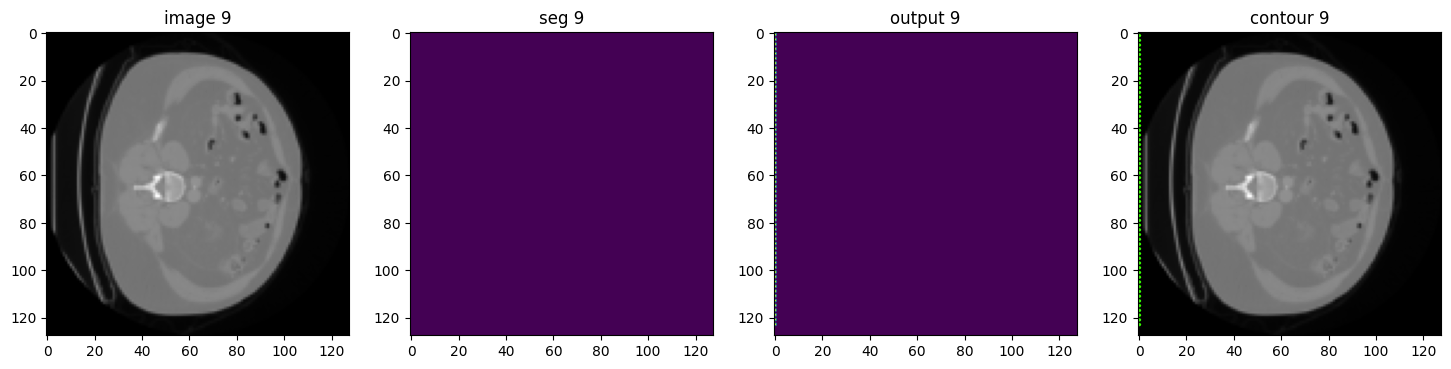

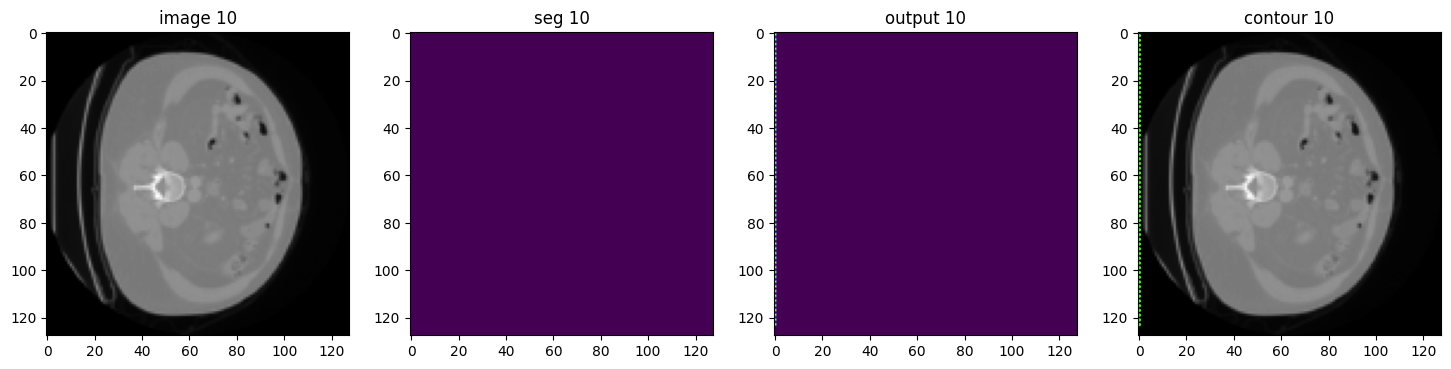

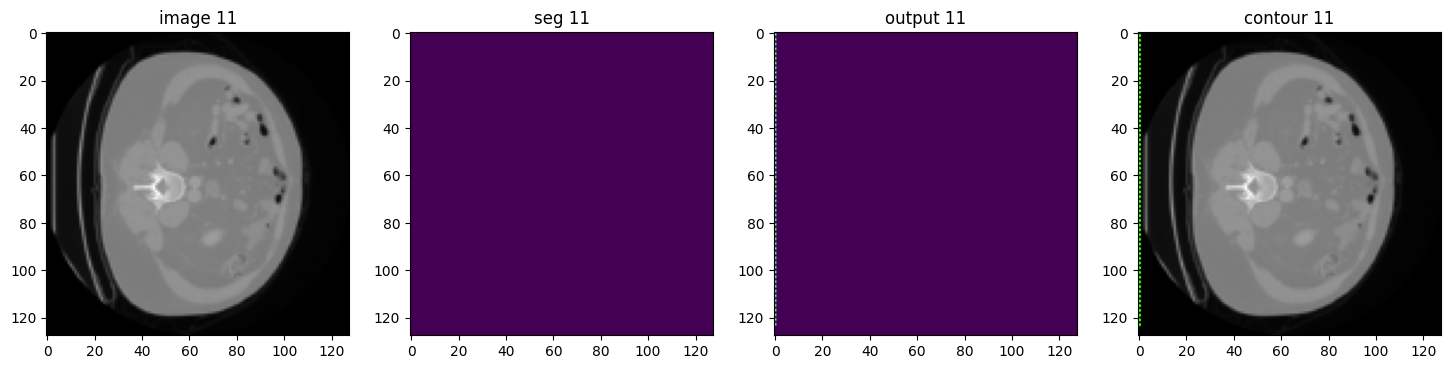

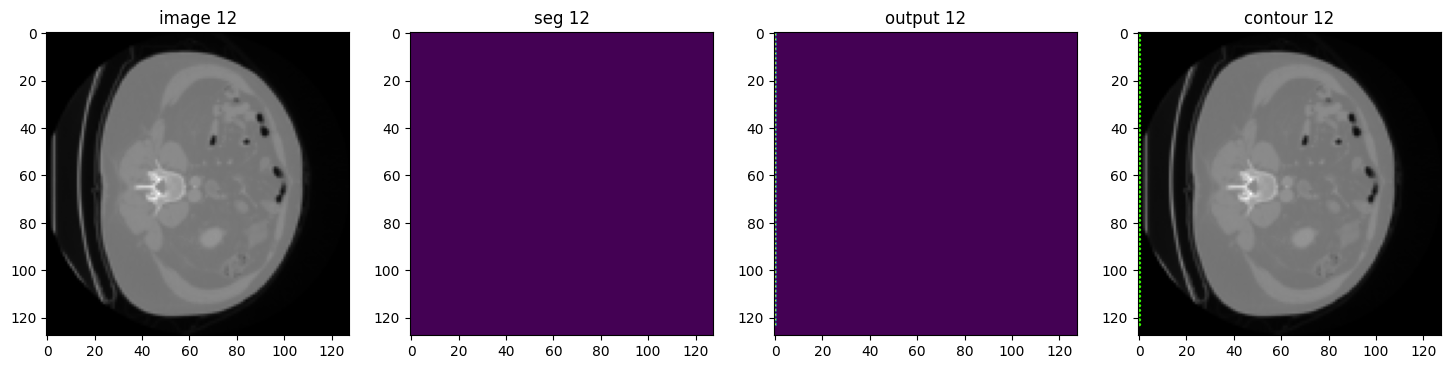

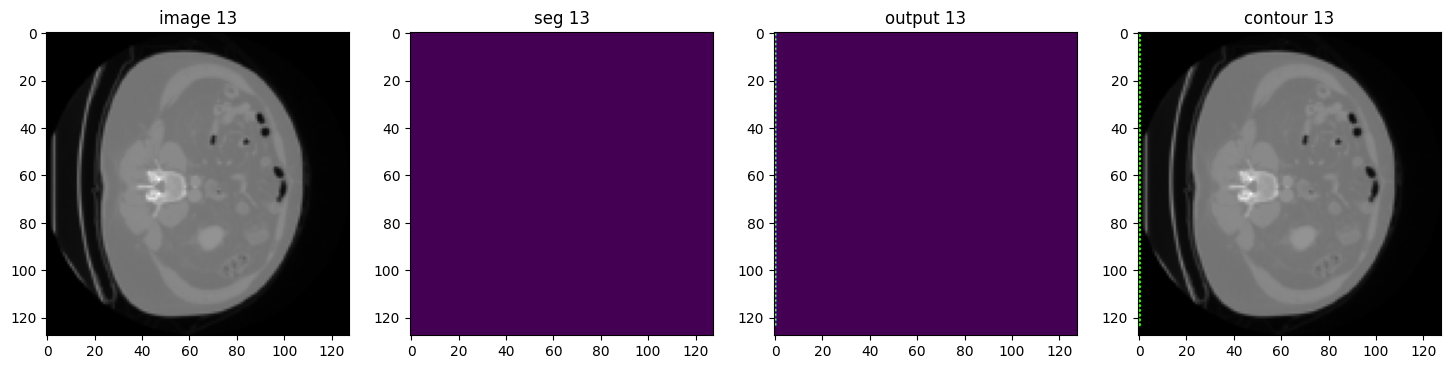

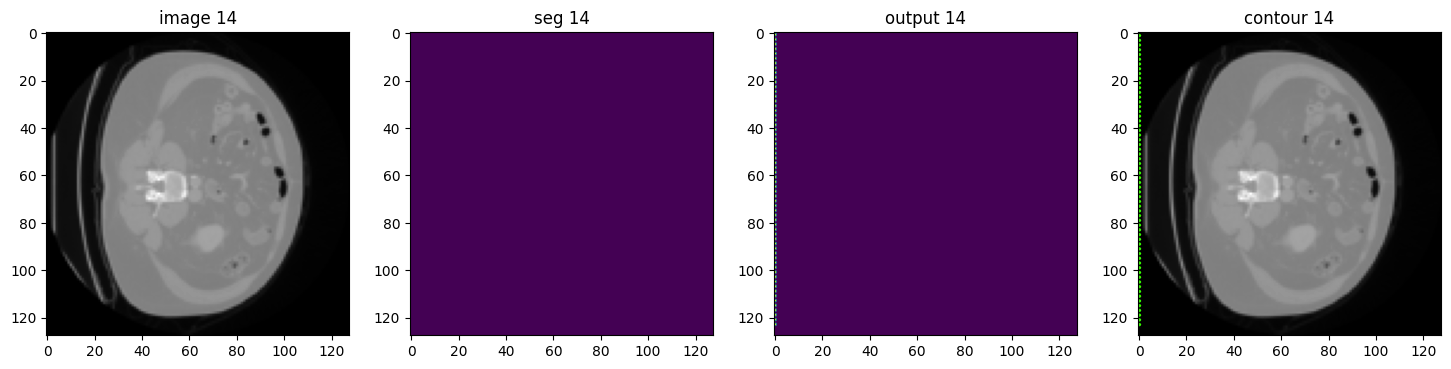

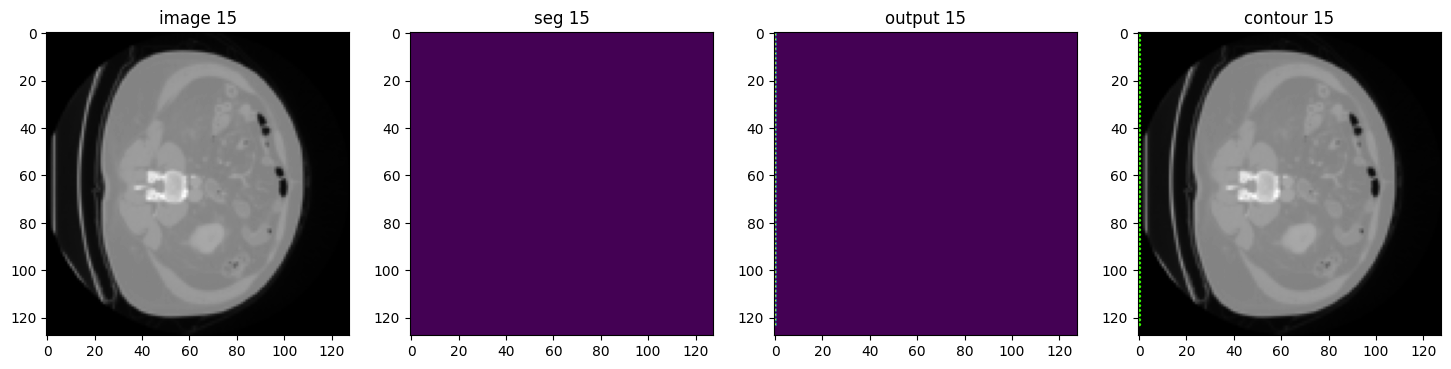

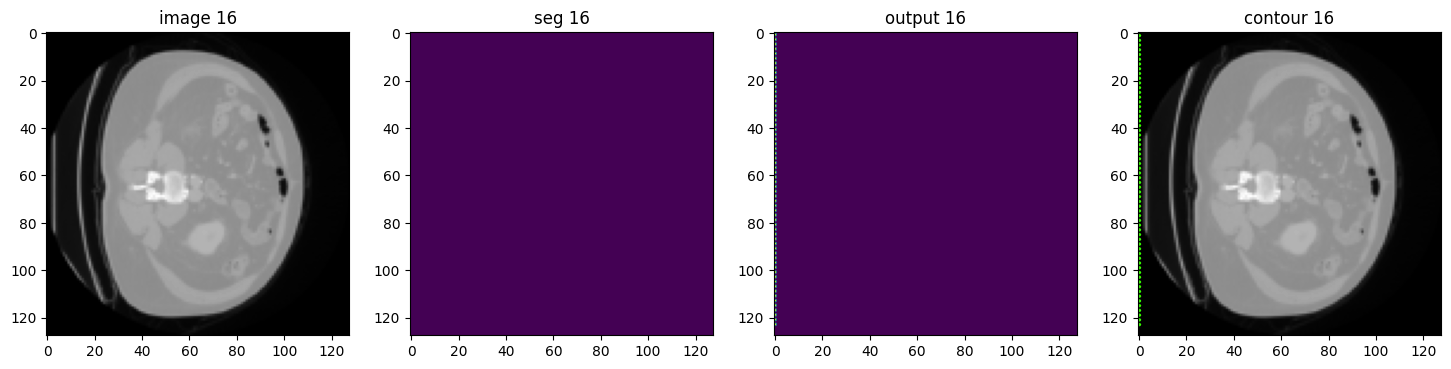

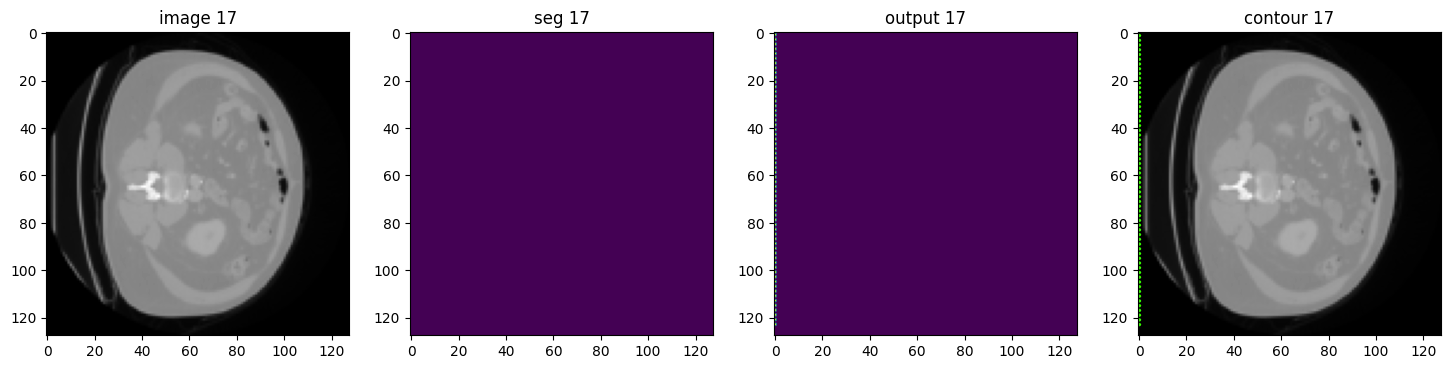

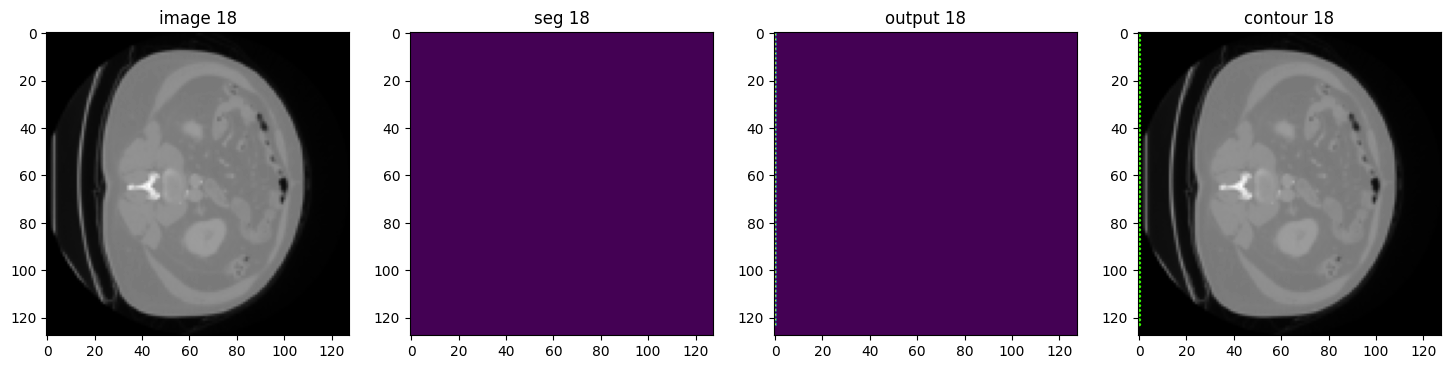

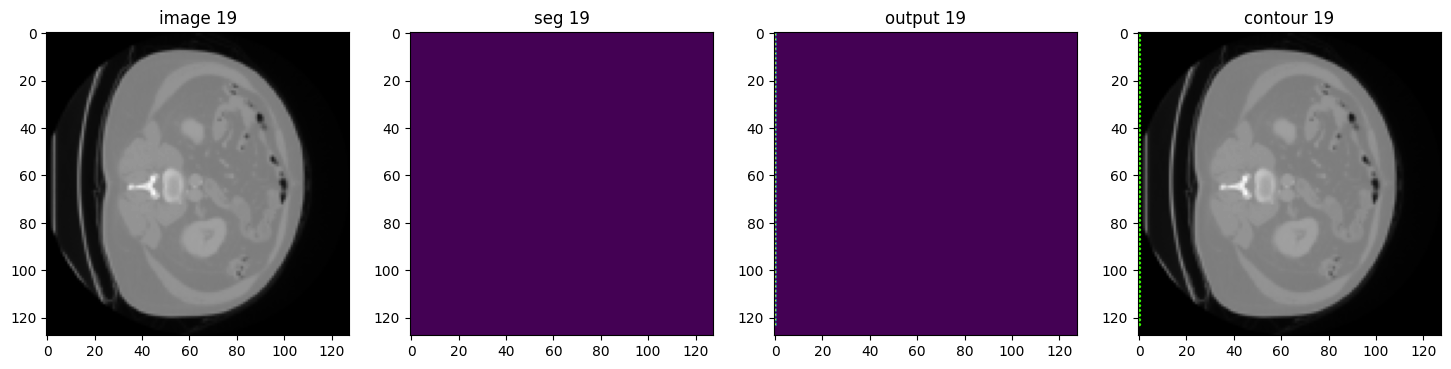

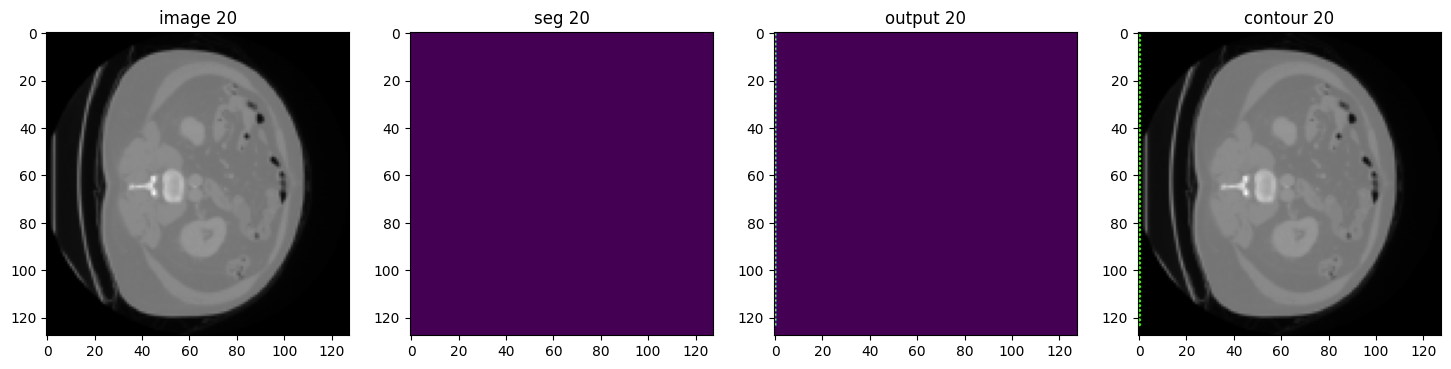

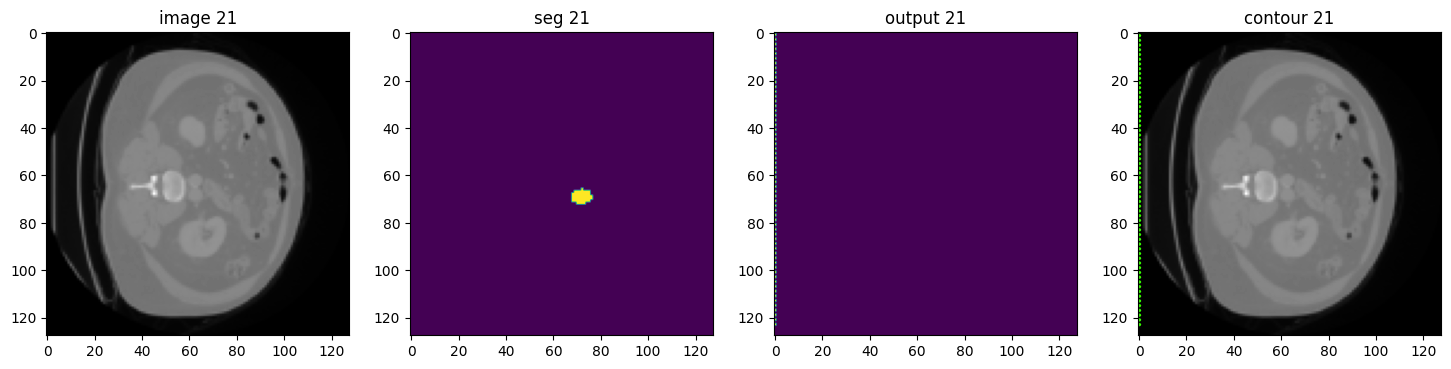

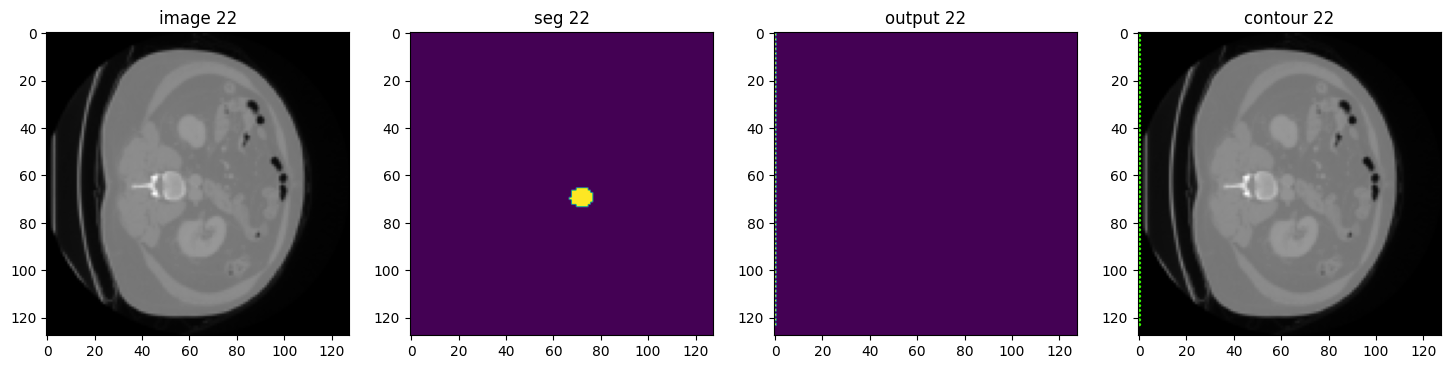

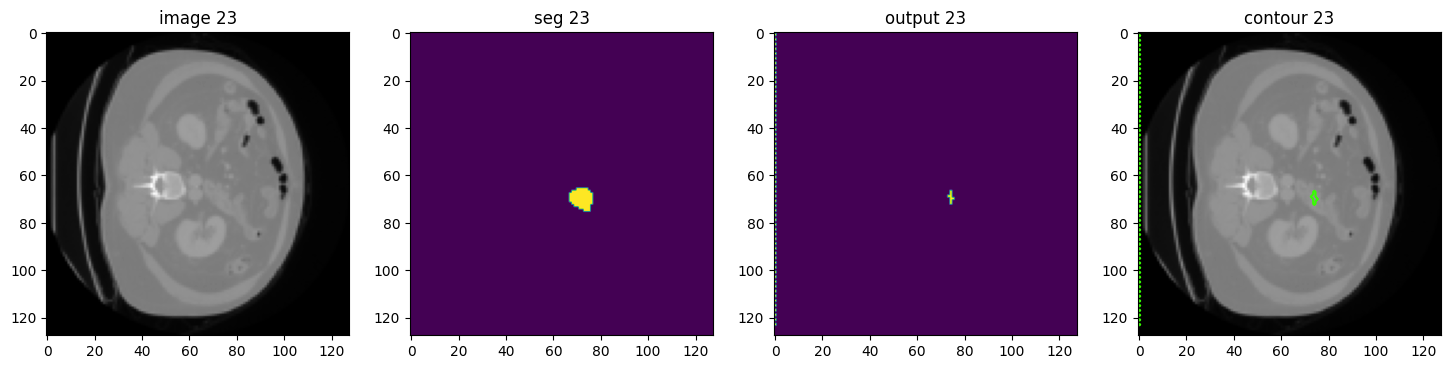

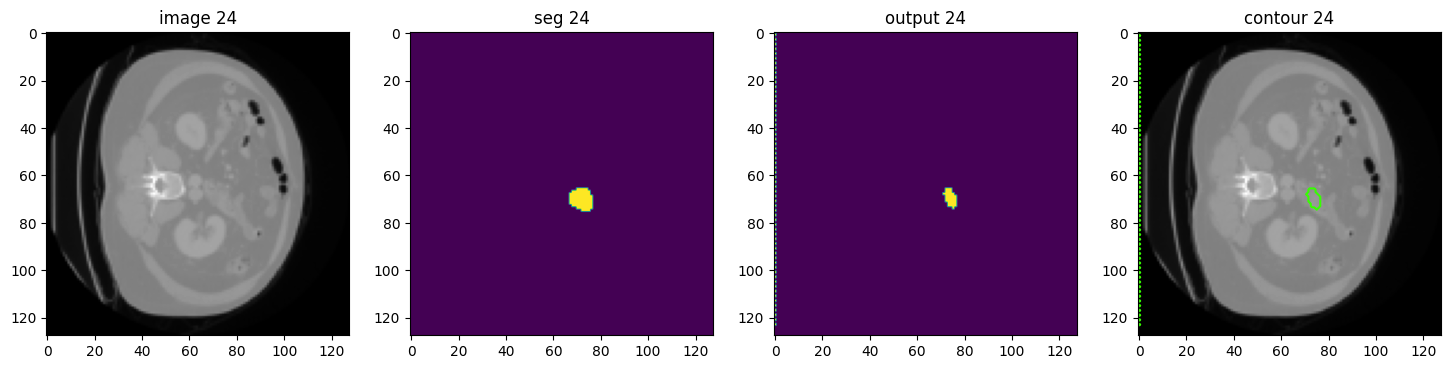

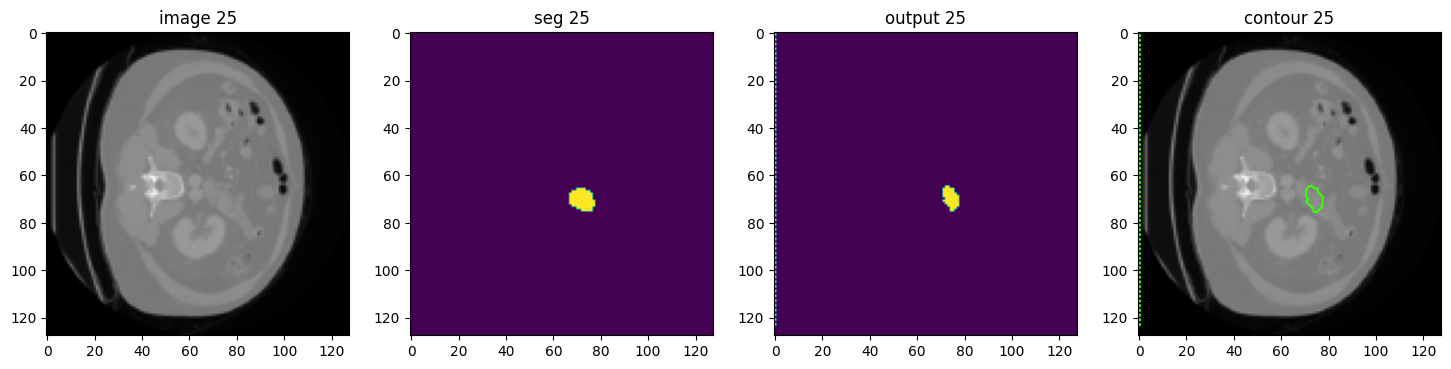

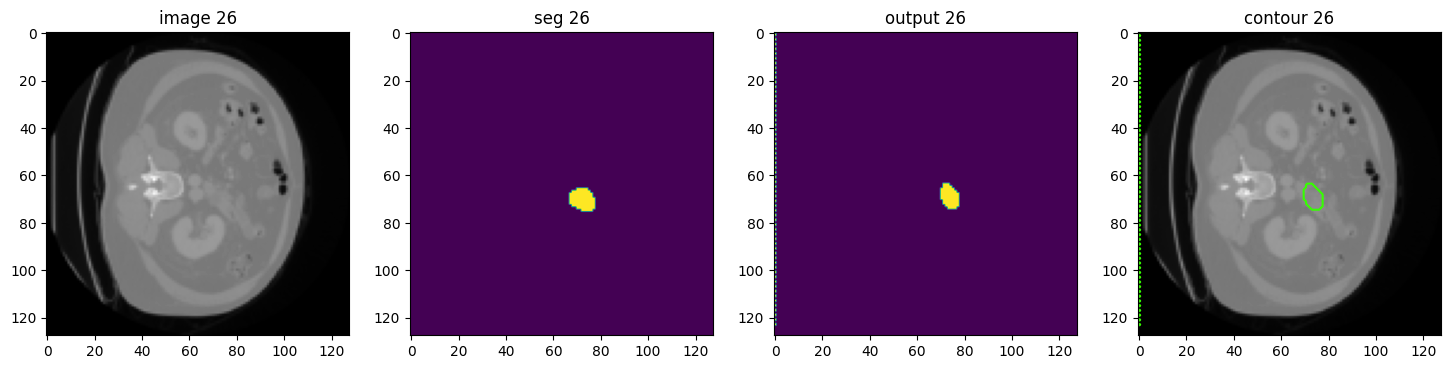

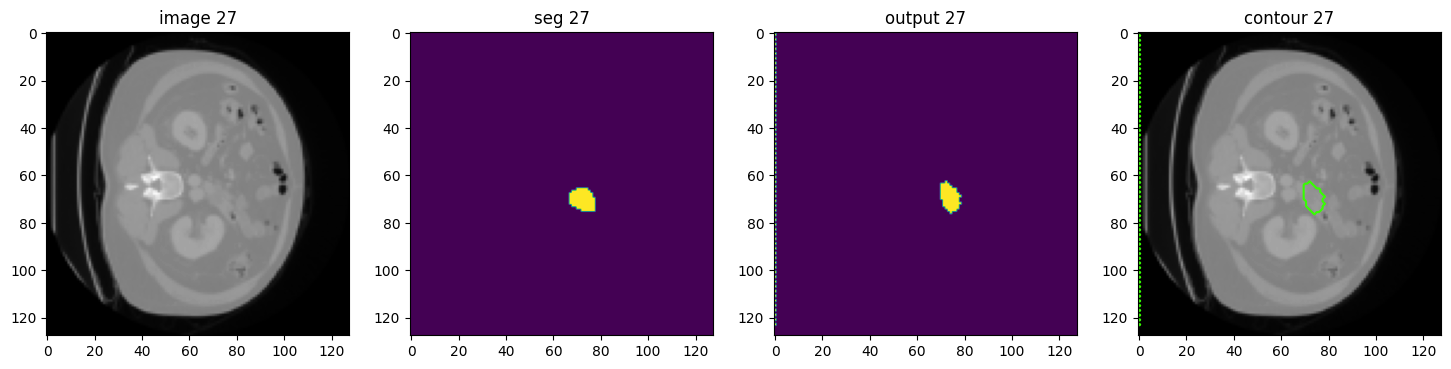

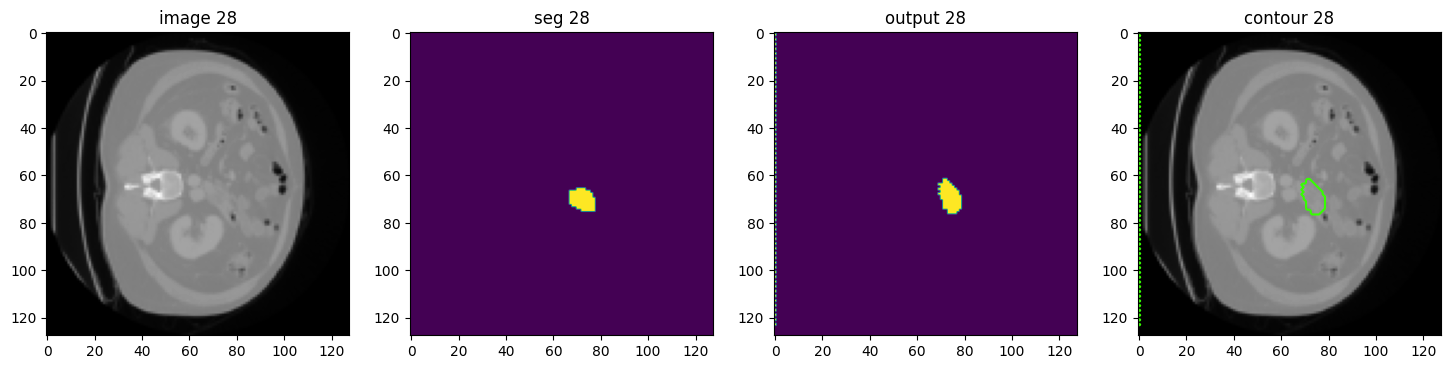

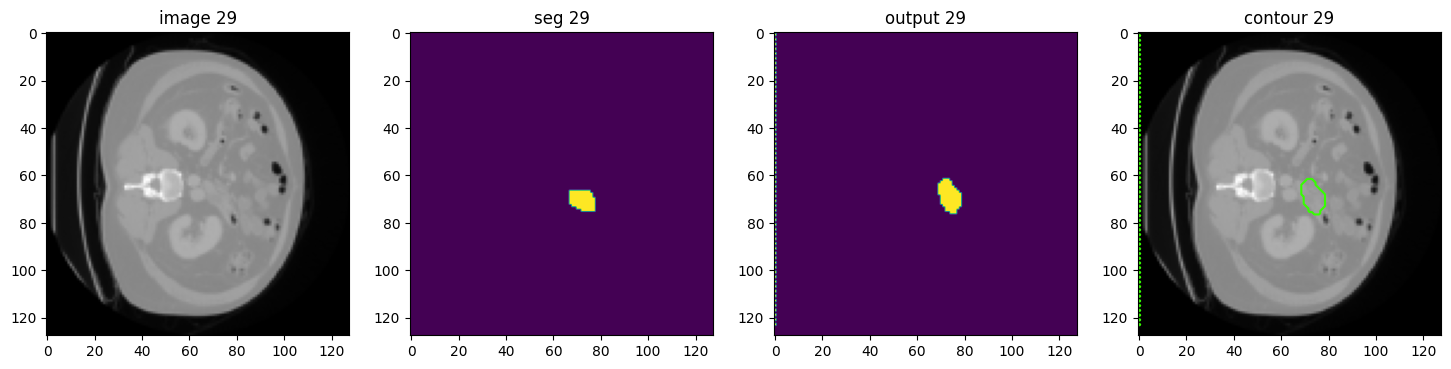

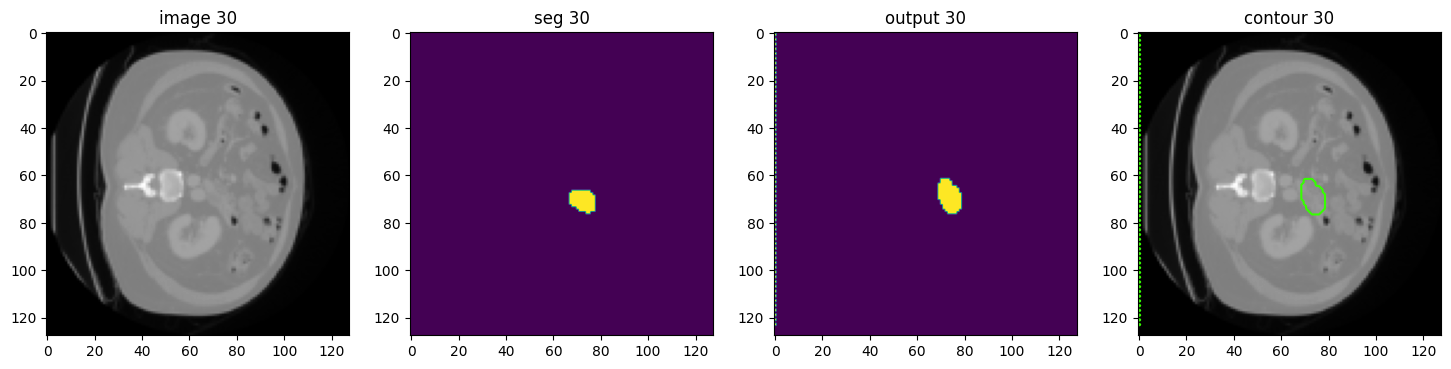

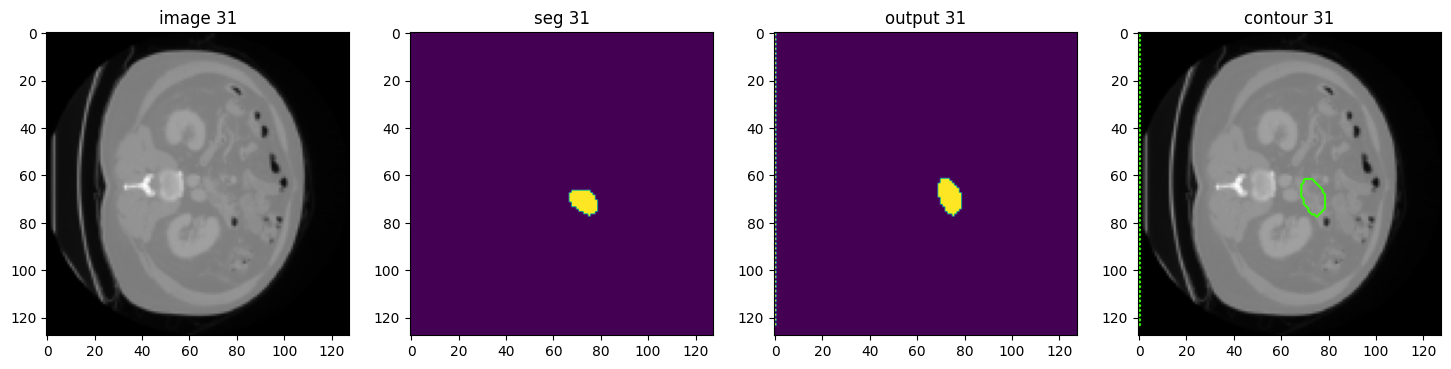

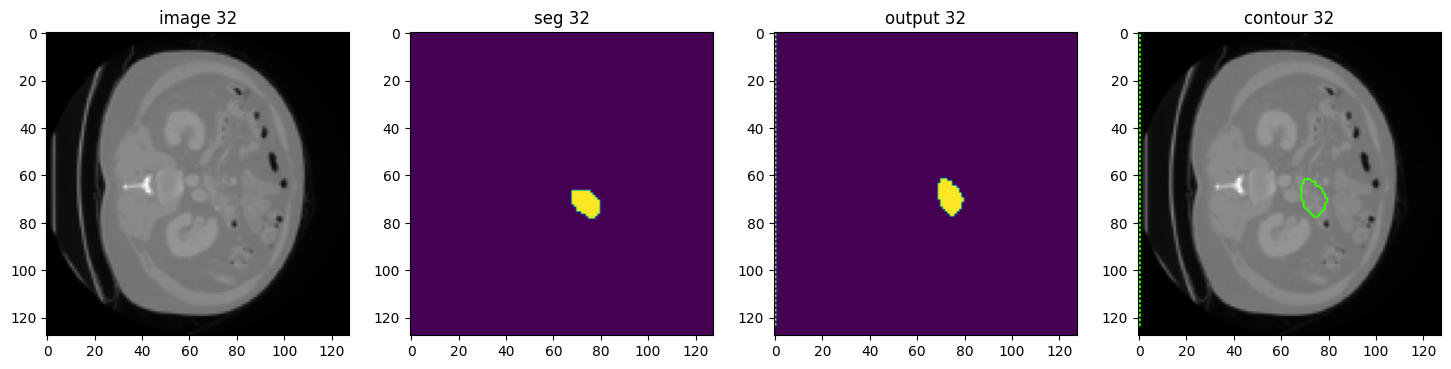

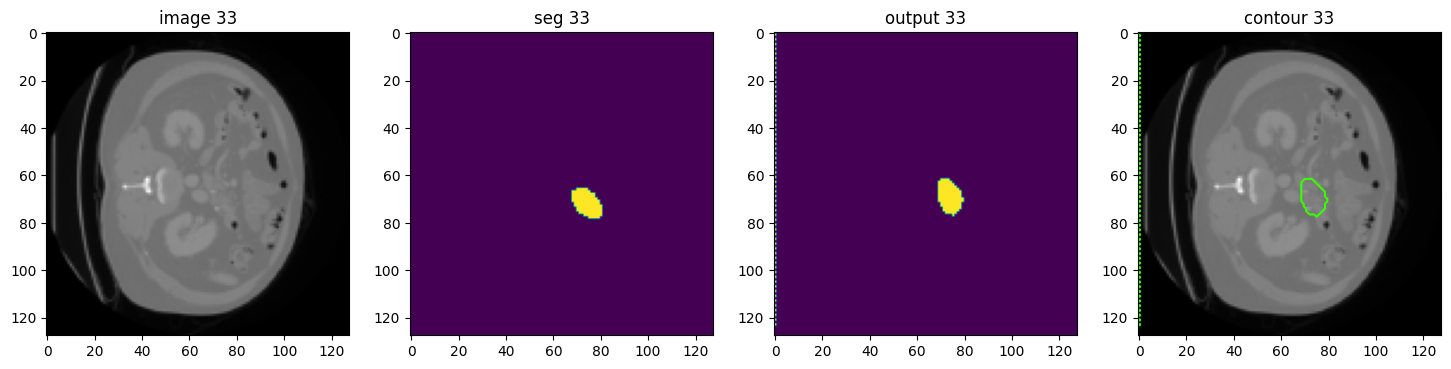

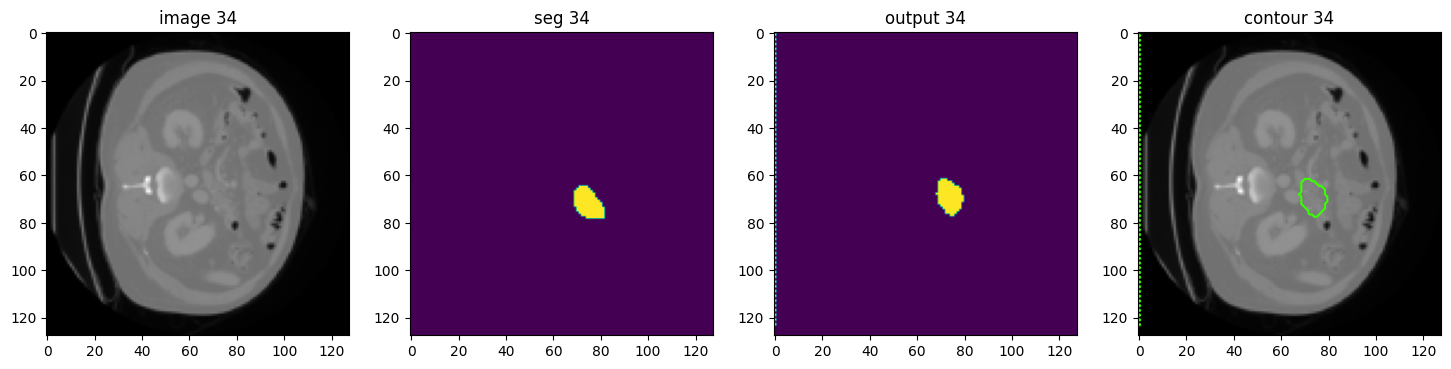

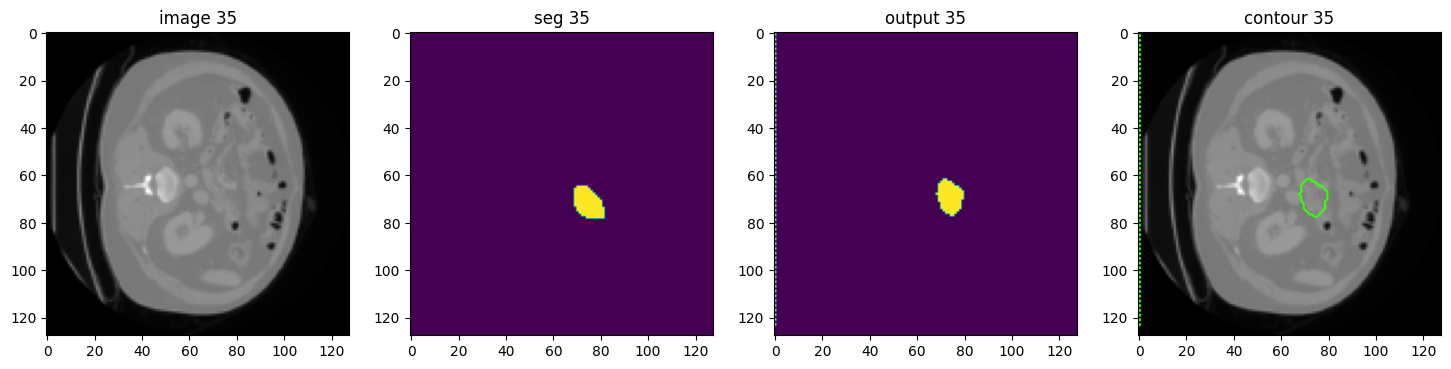

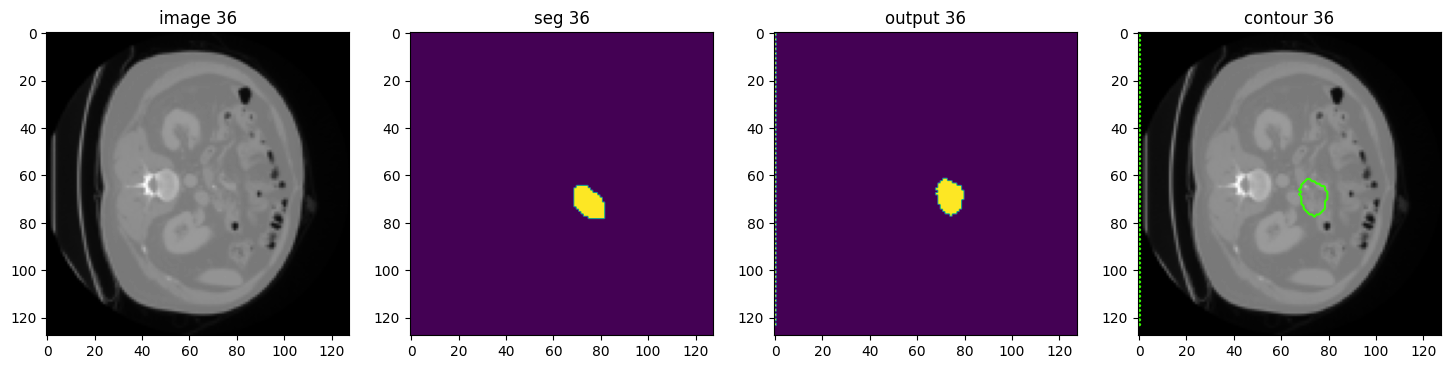

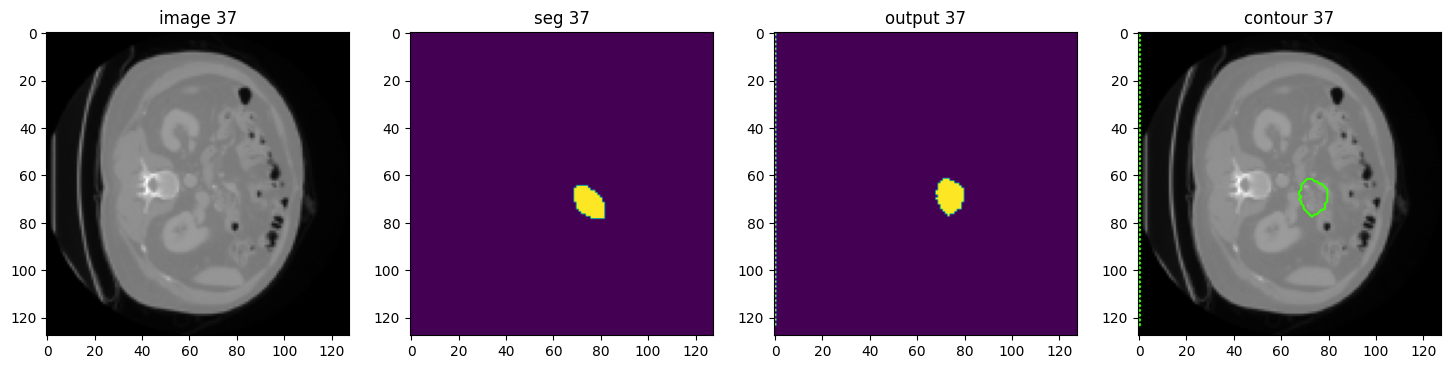

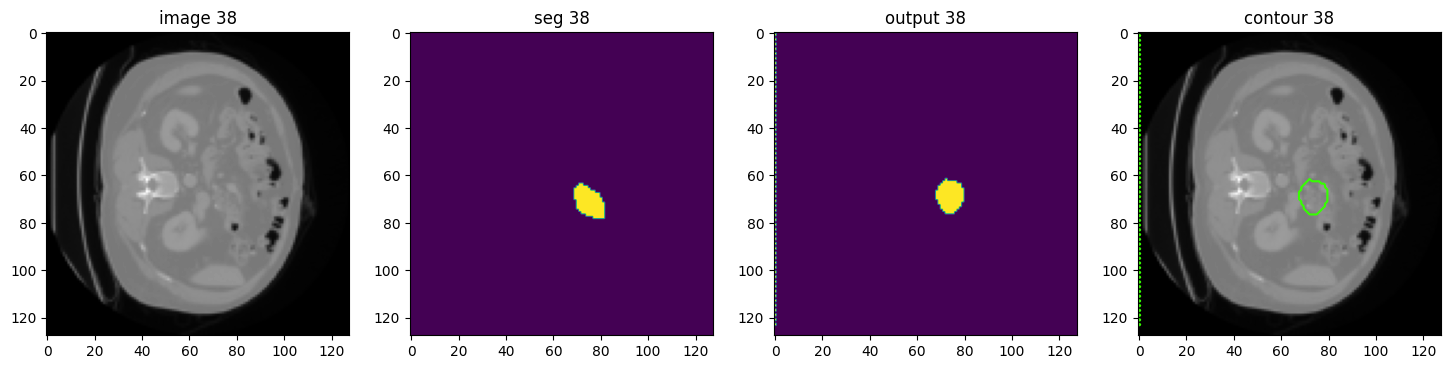

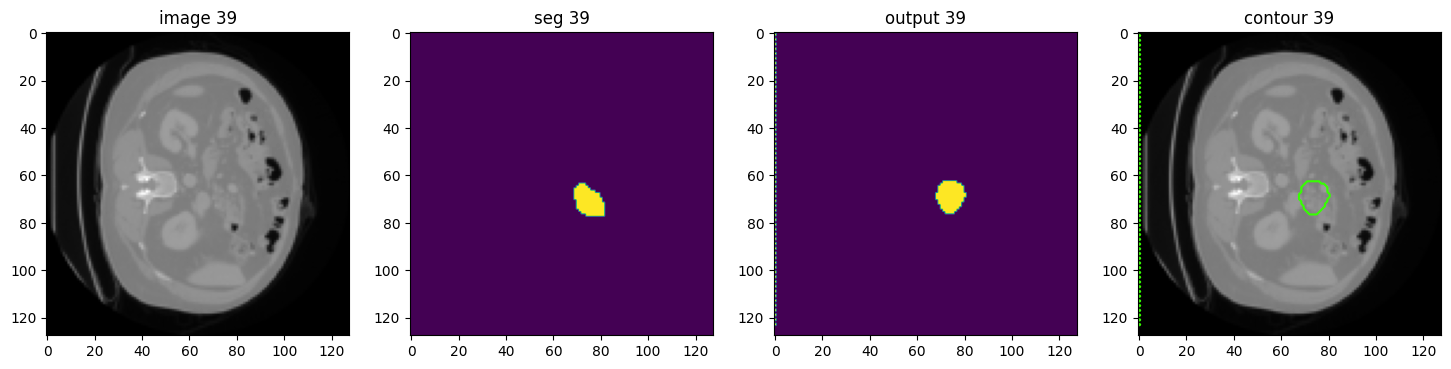

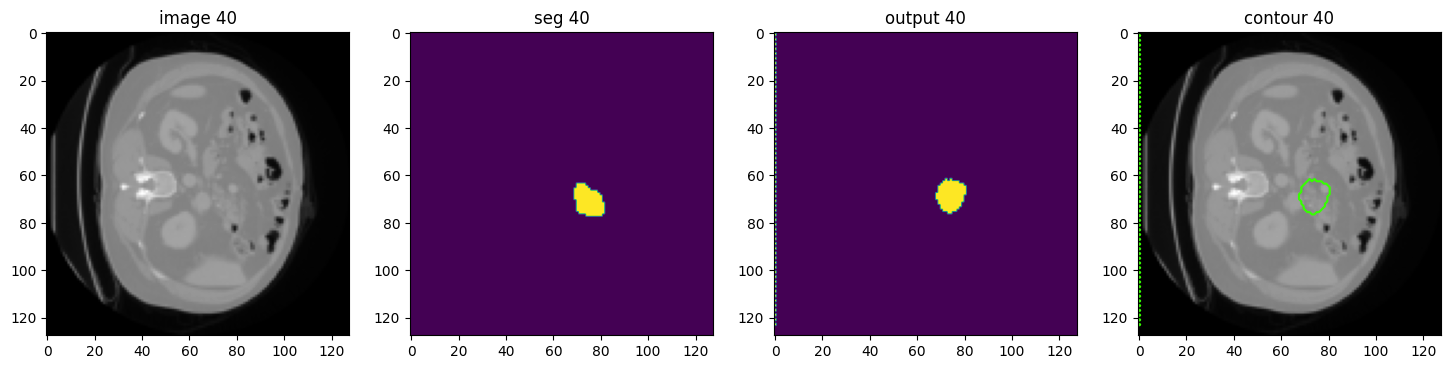

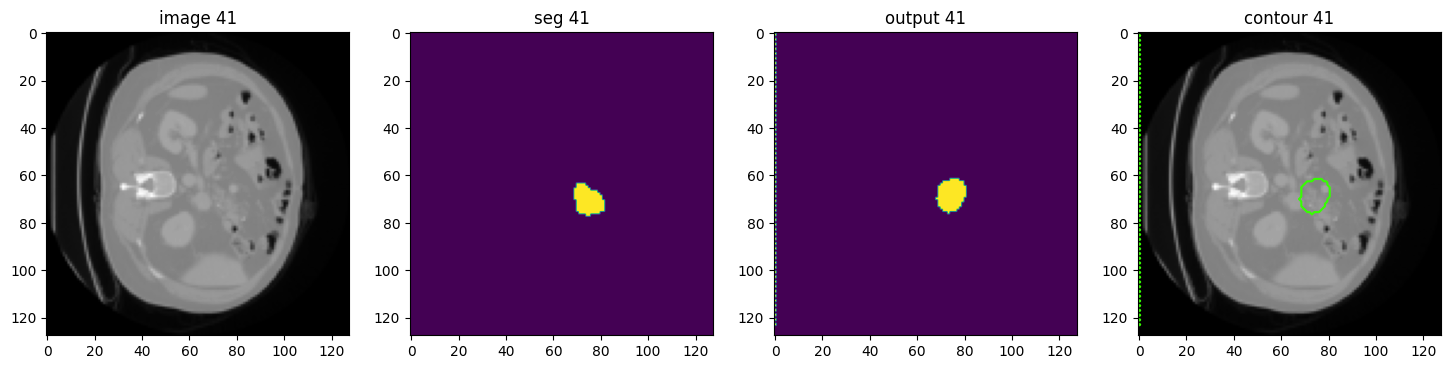

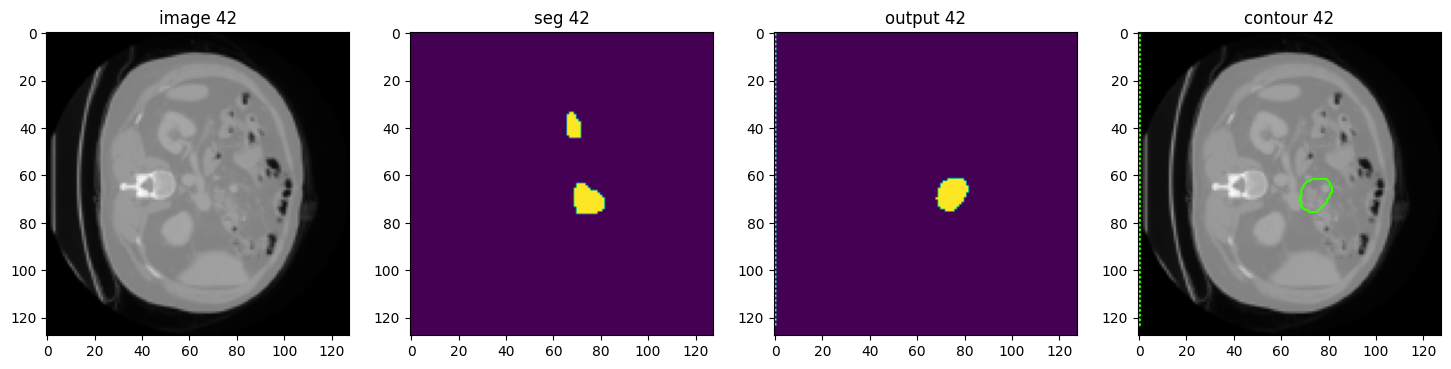

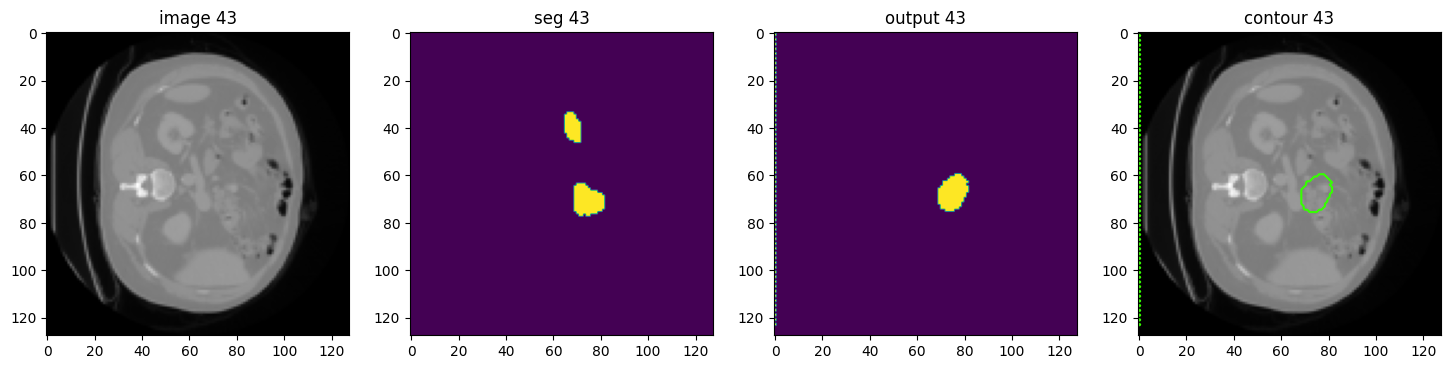

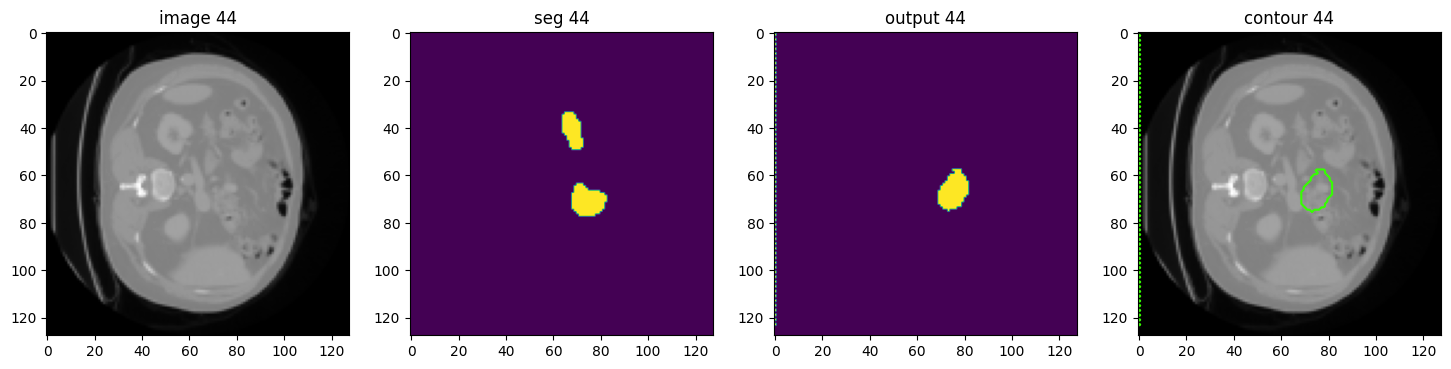

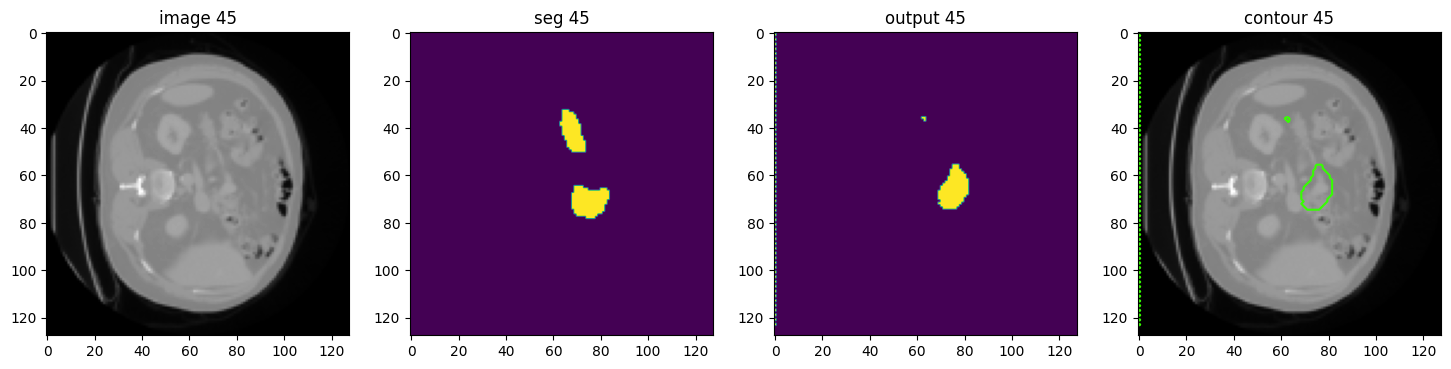

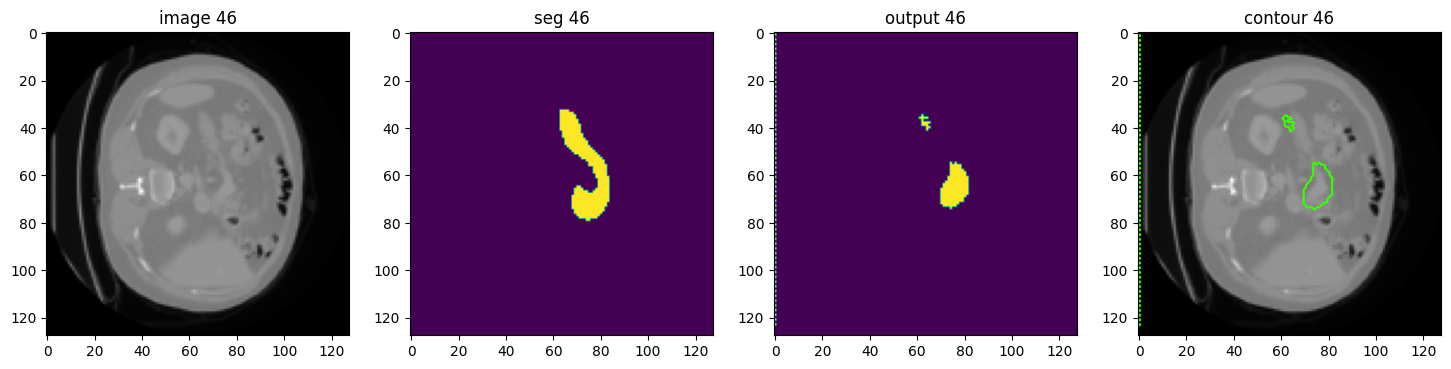

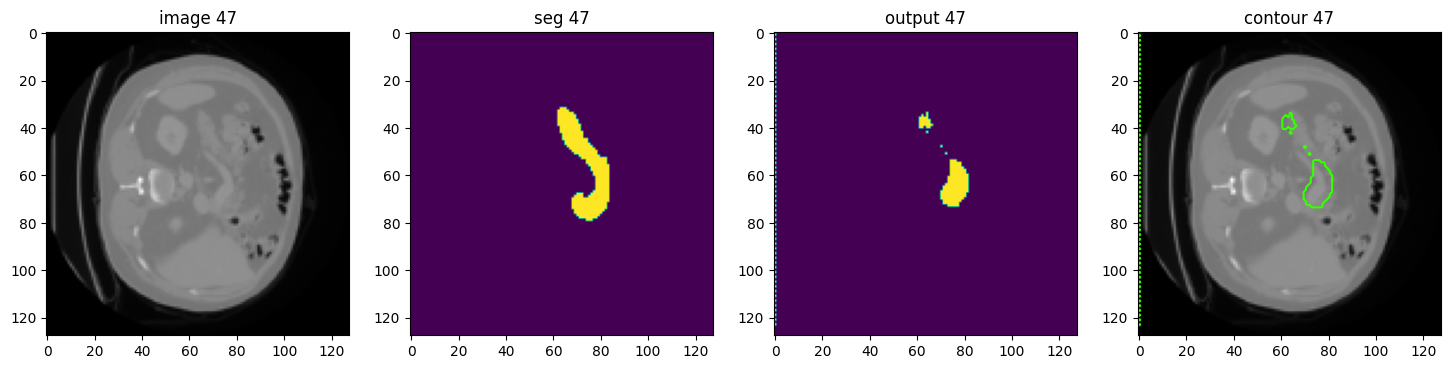

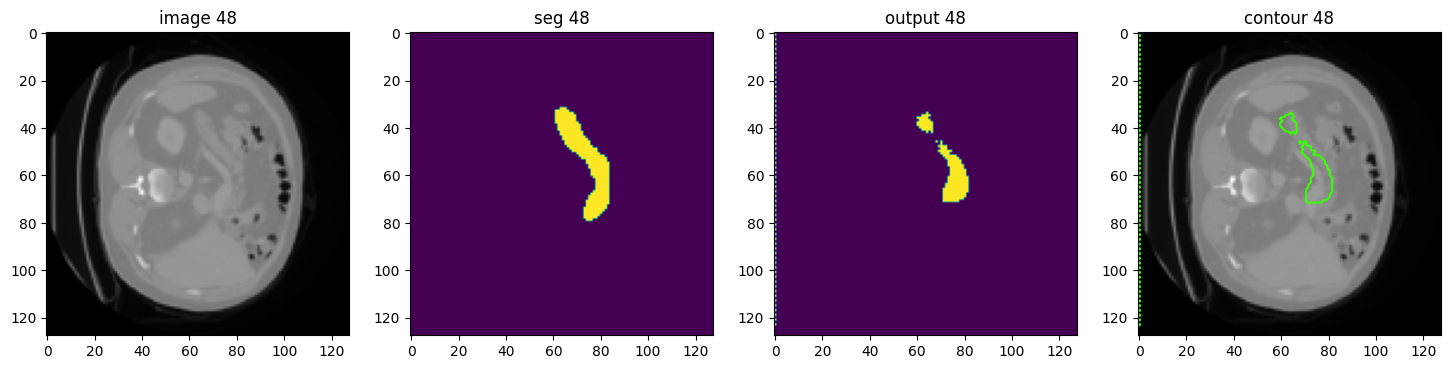

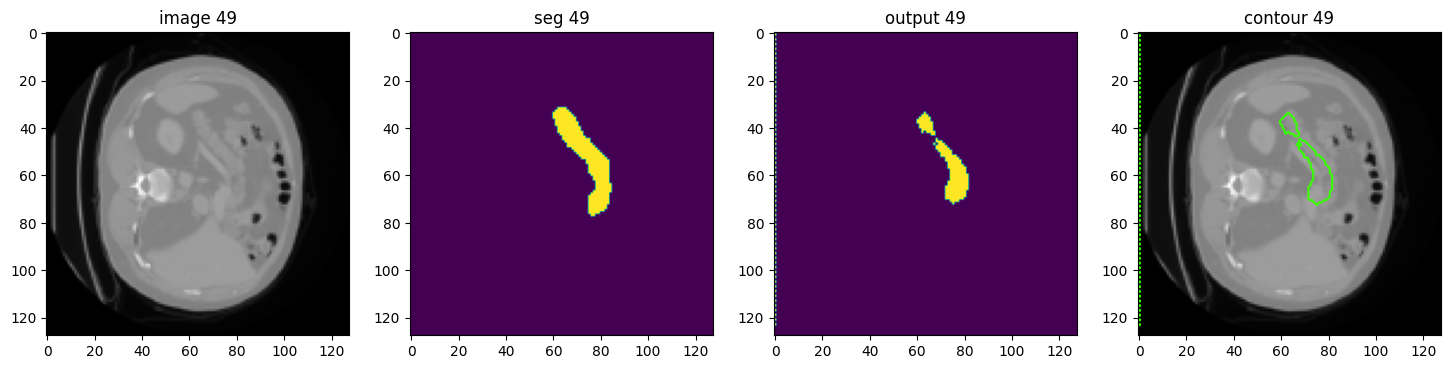

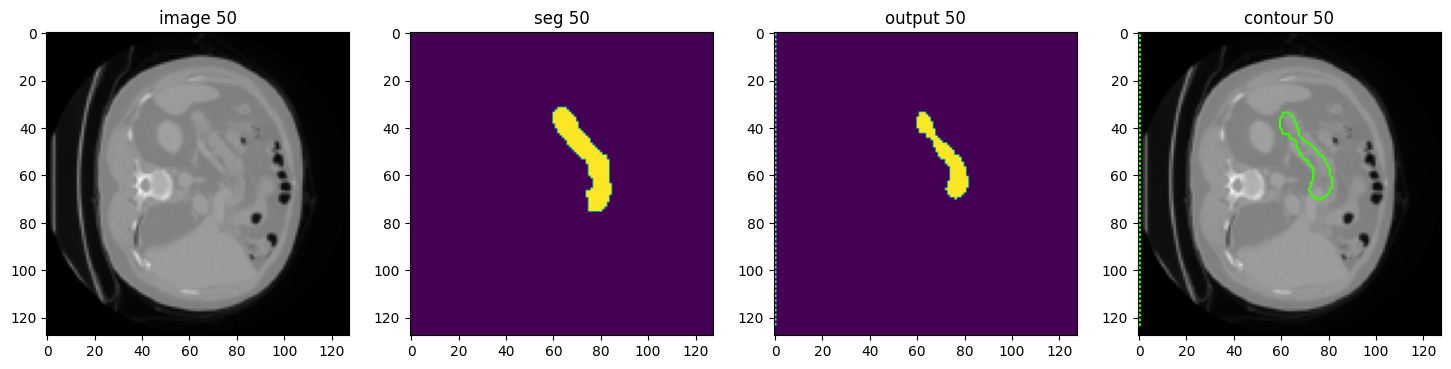

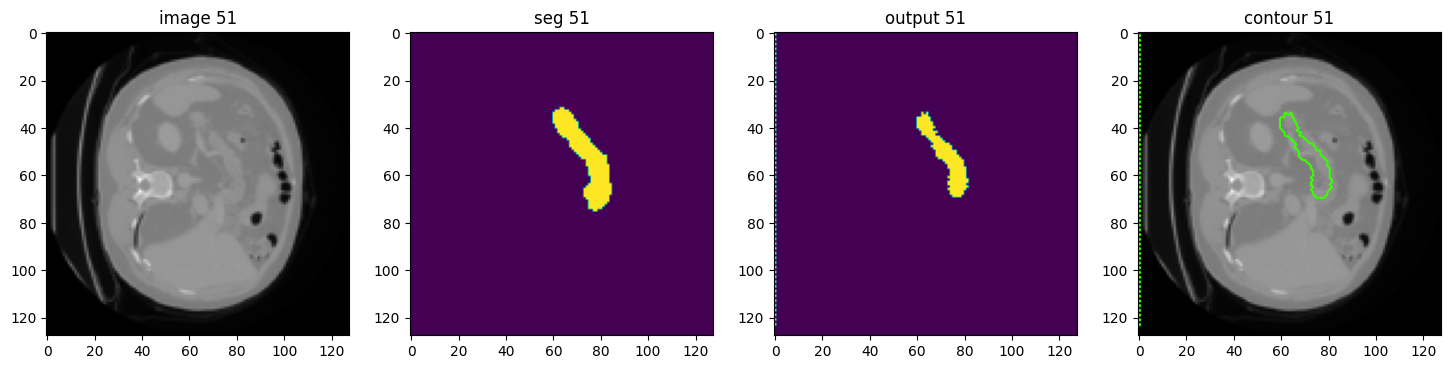

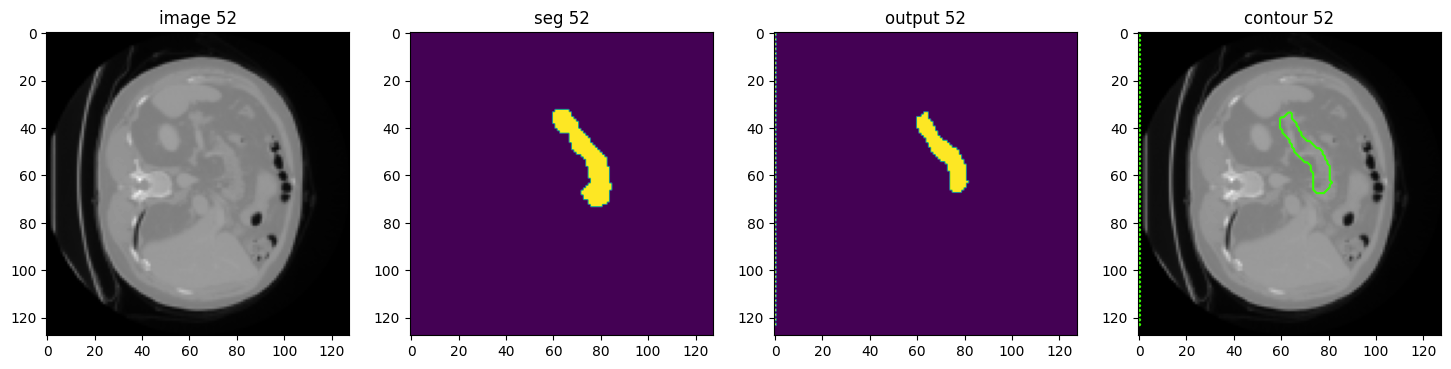

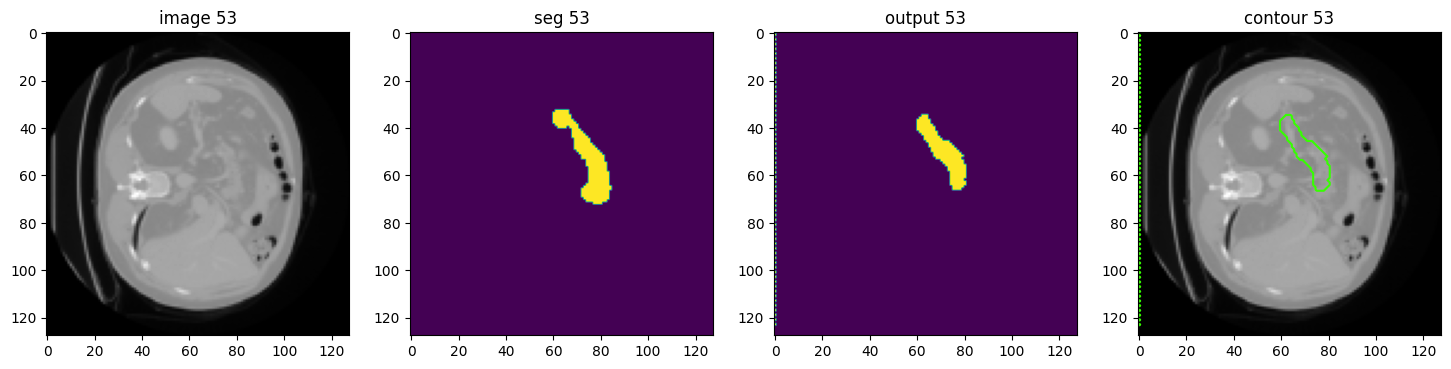

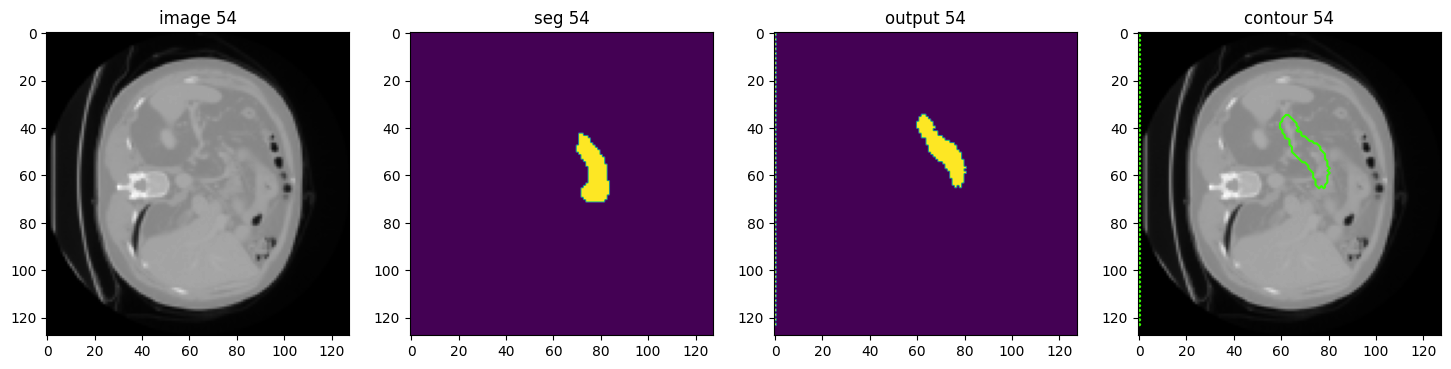

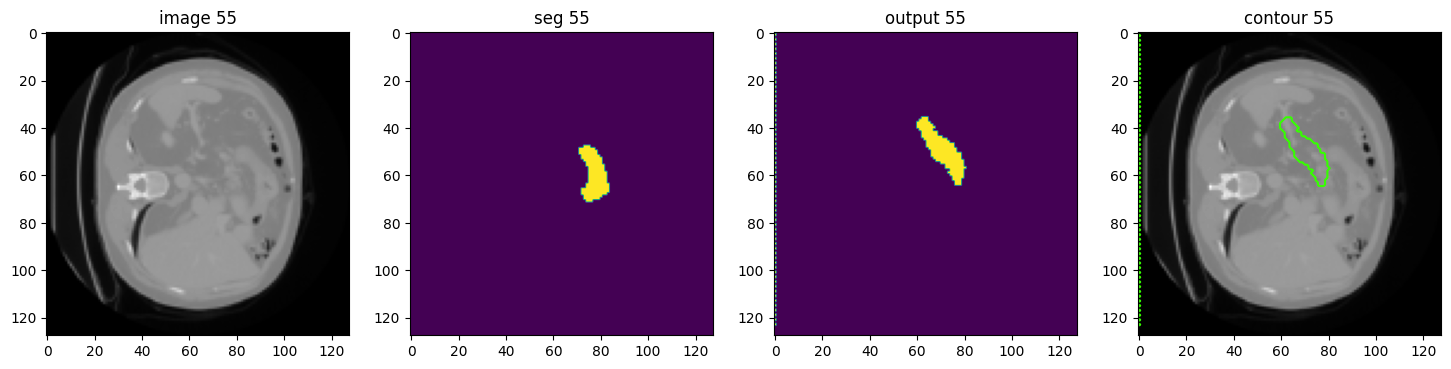

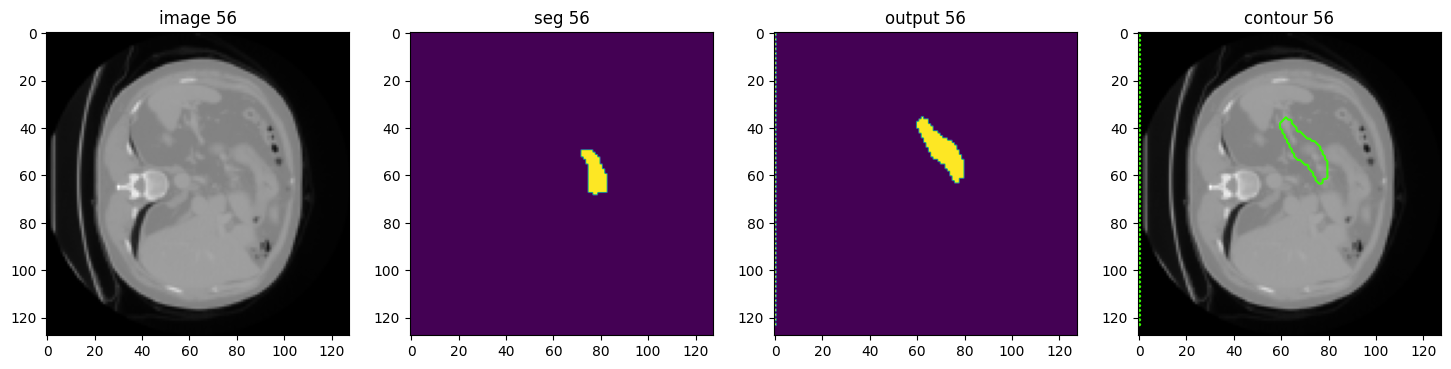

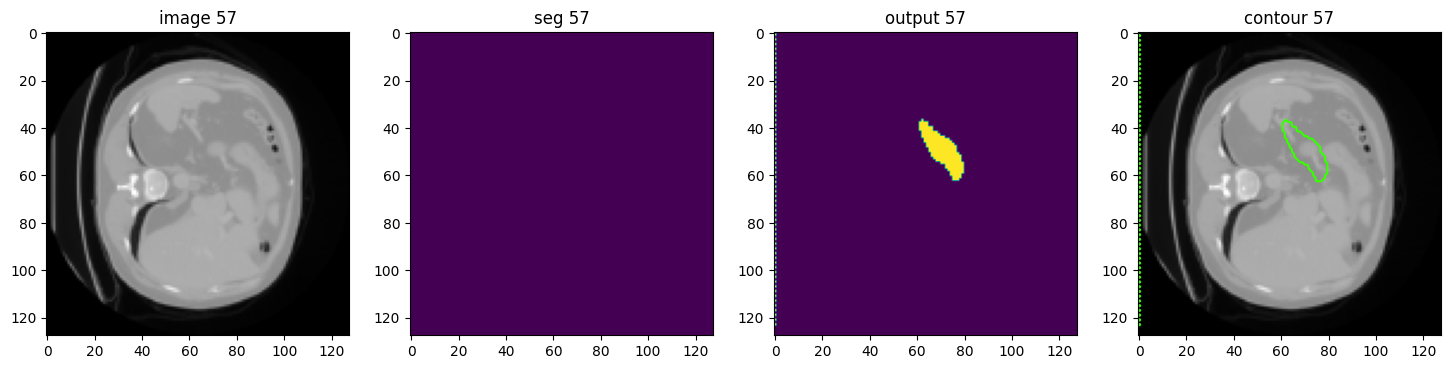

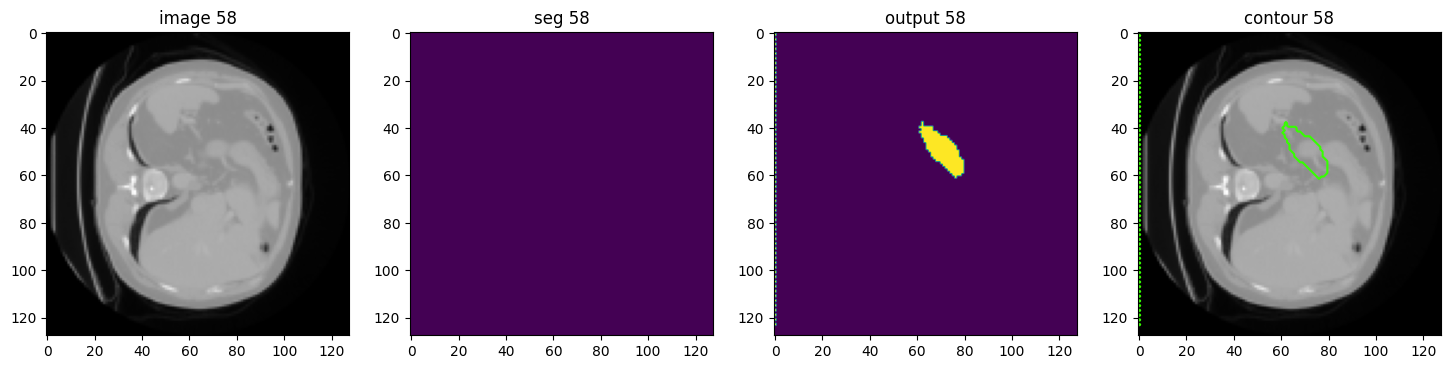

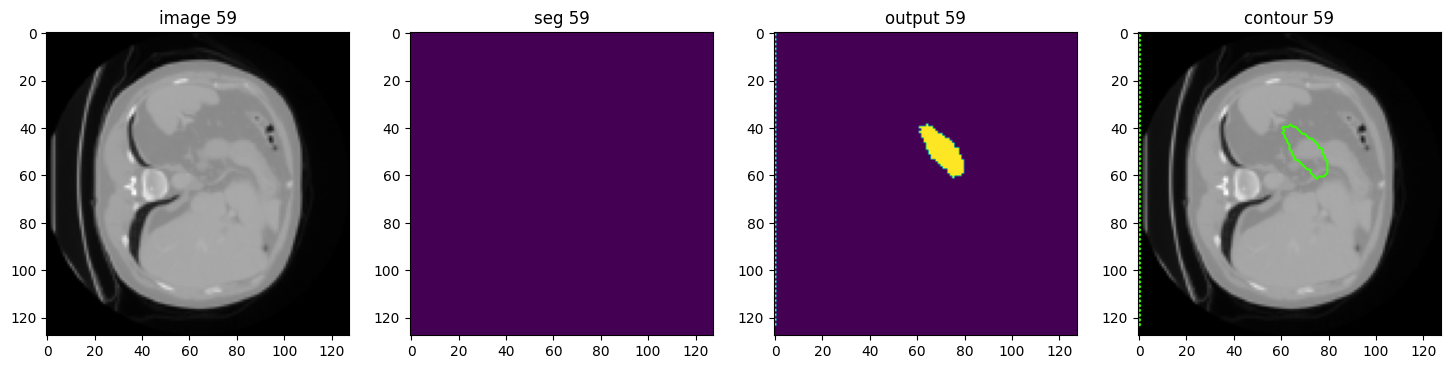

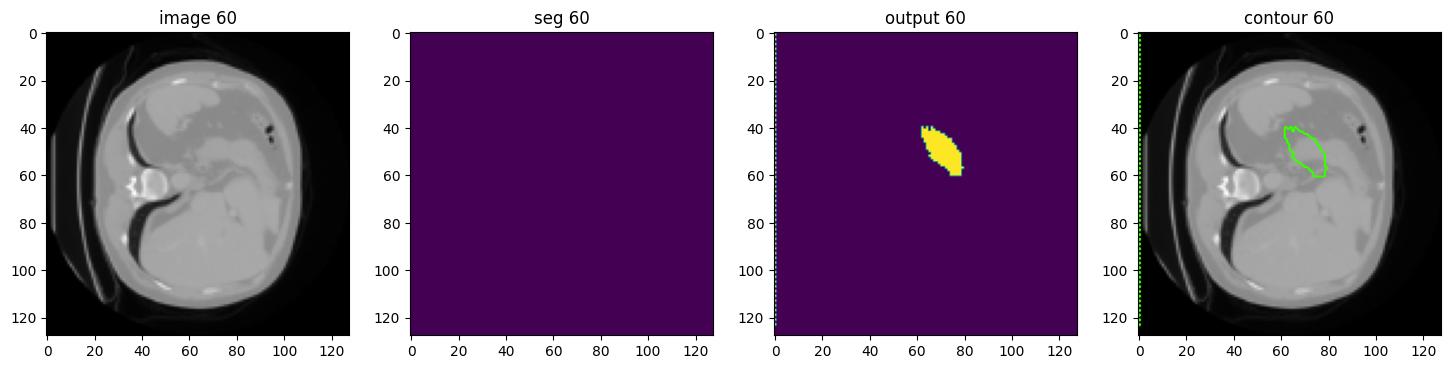

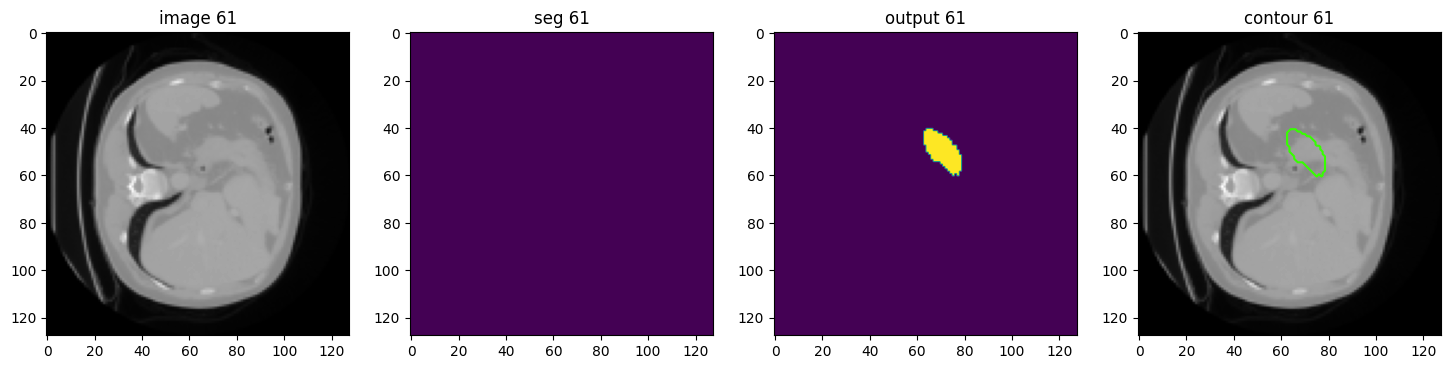

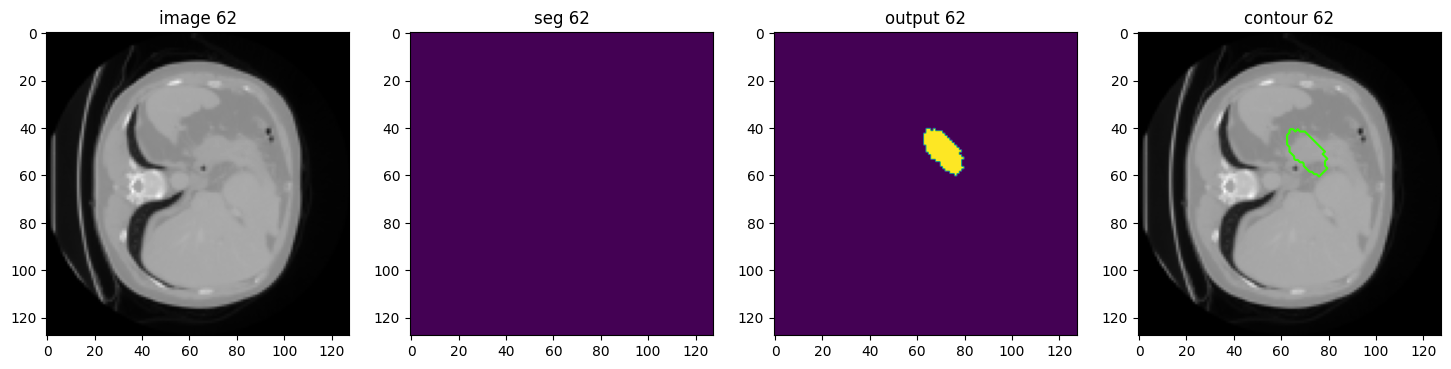

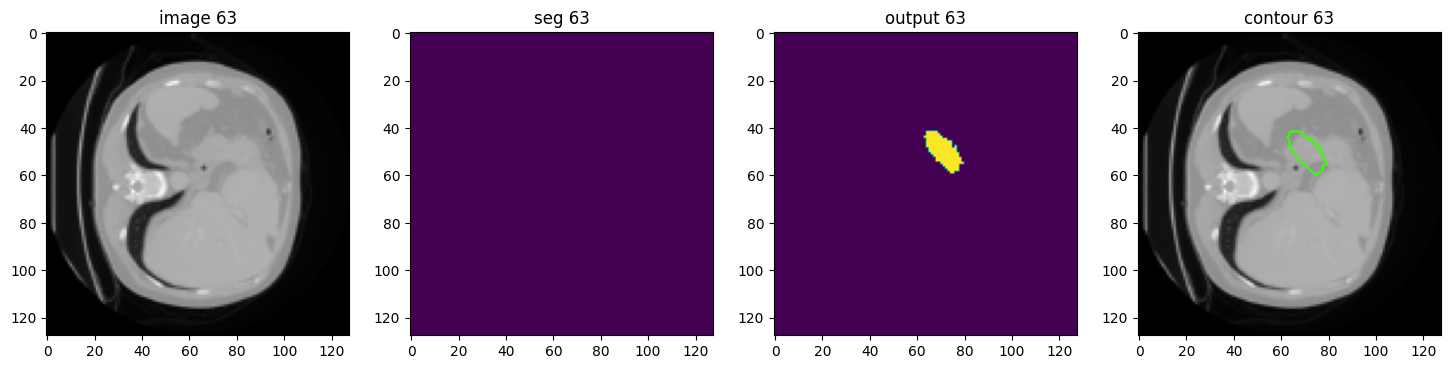

In [22]:
# this code allows you to view the results of the model : the first column contains images, the second contains the ground labels annotated by the physician , the third column contains the predictions of the model,
# the fourth column contains the image produced with a contour around it 
# define the batch size as defined in train.py and the roi_size to match the dimensions of the resize functions
sw_batch_size = 2
roi_size = (128, 128, 64)
with torch.no_grad():
    val_patient = first(val_loader)
    t_volume = val_patient['vol']

    val_outputs = sliding_window_inference(t_volume.to(device), roi_size, sw_batch_size, model)
    sigmoid_activation = Activations(sigmoid=True)
    val_outputs = sigmoid_activation(test_outputs)
    val_outputs = test_outputs > 0.6
        
channel_idx = 1

for i in range(64):
    # Extract the 2D slices from the 3D volumes
    vol_slice = val_patient["vol"][0, 0, :, :, i].cpu().numpy()  # Convert to NumPy array
    seg_slice = val_patient["seg"][0, 0, :, :, i]
    output_slice = val_outputs.detach().cpu()[0, channel_idx, :, :, i].numpy()
    
    # Apply thresholding to create a binary mask
    binary_mask = output_slice
    
    # Find contours in the binary mask using OpenCV
    contours, _ = cv2.findContours(binary_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    plt.figure("check", (18, 12))
    plt.subplot(1, 4, 1)
    plt.title(f"image {i}")
    plt.imshow(vol_slice, cmap="gray")
    
    plt.subplot(1, 4, 2)
    plt.title(f"seg {i}")
    plt.imshow(seg_slice != 0)
    
    plt.subplot(1, 4, 3)
    plt.title(f"output {i}")
    plt.imshow(output_slice)
    
    plt.subplot(1, 4, 4)
    plt.title(f"contour {i}")
    plt.imshow(vol_slice, cmap="gray")
    plt.contour(binary_mask, colors= [(0.21, 1.0, 0.0, 1.0)] , levels=[0.5], linewidths=1.5)  # contour
    
    plt.show()

In [24]:
# This part of the code creates an nii.gz file of the image and another with the segmentation predicted it that is able to be viewed on 3DSlicer or ITKsnap
target_size = (512, 512, 64)  # Specify your desired target size

# Convert the val_patient['vol'] tensor to a NumPy array
input_array = val_patient['vol'][0, 0].detach().cpu().numpy()

# Resize the test patient volume and the stacked segmentation output to the target size
resized_input = np.zeros(target_size, dtype=np.float32)
resized_output = np.zeros(target_size, dtype=np.uint8)
for i in range(input_array.shape[2]):
    resized_input[..., i] = resize(input_array[..., i], target_size[:2], preserve_range=True)
    resized_output[..., i] = resize(test_outputs.detach().cpu()[0, 1, ..., i], target_size[:2], 
                                    order=0, anti_aliasing=False, preserve_range=True)

# Save the resized segmentation output as a NIfTI file
output_folder = "./output_nii"
os.makedirs(output_folder, exist_ok=True)

segmentation_filename = os.path.join(output_folder, "segmentation_val.nii.gz")
affine = None  # Update with the correct affine matrix if available
nib.save(nib.Nifti1Image(resized_output, affine), segmentation_filename)

# Save the resized input images as a NIfTI file
input_filename = os.path.join(output_folder, "input_images_val.nii.gz")
nib.save(nib.Nifti1Image(resized_input, affine), input_filename)

# Print the dimensions of the resized NIfTI volume
segmentation_shape = resized_output.shape
print(f"Dimensions of resized segmentation: {segmentation_shape}")

input_shape = resized_input.shape
print(f"Dimensions of resized input images: {input_shape}")





Dimensions of resized segmentation: (512, 512, 64)
Dimensions of resized input images: (512, 512, 64)


In [28]:
# This part of the code creates an nii.gz file of the image and its contours around it that is able to be viewed on 3DSlicer or ITKsnap

# Create an empty array to store images with contours
images_with_contours = []

for i in range(64):
    # Extract the 2D slices from the 3D volumes
    vol_slice = val_patient["vol"][0, 0, :, :, i].cpu().numpy()
    output_slice = val_outputs.detach().cpu()[0, 1, :, :, i].numpy()
    
    # Apply thresholding to create a binary mask
    binary_mask = output_slice
    
    # Find contours in the binary mask using OpenCV
    contours, _ = cv2.findContours(binary_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create an empty black image for overlaying the contours
    contour_overlay = np.zeros_like(vol_slice, dtype=np.uint8)
    
    # Overlay the contours on the empty image
    cv2.drawContours(contour_overlay, contours, -1, (255, 0, 0), thickness=1)
    
    # Convert the arrays to the same data type and scaling
    vol_slice = ((vol_slice - vol_slice.min()) / (vol_slice.max() - vol_slice.min()) * 255).astype(np.uint8)
    contour_overlay = ((contour_overlay - contour_overlay.min()) / (contour_overlay.max() - contour_overlay.min()) * 255).astype(np.uint8)
    
    # Combine the original image and the contour overlay
    image_with_contour = cv2.addWeighted(vol_slice, 0.5, contour_overlay, 0.5, 0)
    
    images_with_contours.append(image_with_contour)

# Stack the images with contours along the z-axis to create a 3D volume
images_with_contours_volume = np.stack(images_with_contours, axis=-1)

# Resize the images with contours to the target size
target_size = (512, 512, 64)  # Specify your desired target size
resized_images_with_contours = resize(images_with_contours_volume, target_size, order=1, anti_aliasing=True, preserve_range=True)

# Save the resized images with contours volume as a NIfTI file
output_folder = "./output_nii"
os.makedirs(output_folder, exist_ok=True)

images_with_contours_filename = os.path.join(output_folder, "images_with_contours_val.nii.gz")
affine = None  # Update with the correct affine matrix if available
nib.save(nib.Nifti1Image(resized_images_with_contours, affine), images_with_contours_filename)

# Print the dimensions of the resized NIfTI volume
volume_shape = resized_images_with_contours.shape
print(f"Dimensions of resized images with contours: {volume_shape}")

/tmp/ipykernel_3065506/2570836827.py:25: RuntimeWarning: invalid value encountered in divide
  contour_overlay = ((contour_overlay - contour_overlay.min()) / (contour_overlay.max() - contour_overlay.min()) * 255).astype(np.uint8)
/tmp/ipykernel_3065506/2570836827.py:25: RuntimeWarning: invalid value encountered in cast
  contour_overlay = ((contour_overlay - contour_overlay.min()) / (contour_overlay.max() - contour_overlay.min()) * 255).astype(np.uint8)


Dimensions of resized images with contours: (512, 512, 64)
